In [1]:
# ============================
# Install Necessary Libraries
# ============================
!pip install PyWavelets
!pip install ultralytics
!pip install wandb
!pip install -U ipywidgets

# ============================
# Show Keras and TensorFlow Installation
# ============================
# !pip show keras tensorflow

# ============================
# Clear Output in Notebook
# ============================
from IPython import display
display.clear_output()

In [ ]:
f0668009b17e1c20c9d64e5b65e924f908ed2be6


In [2]:
import logging
import random
import numpy as np
import os
import torch
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
from PIL import Image
from IPython.display import display
import wandb
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [5]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

In [2]:
import os
from collections import Counter
import glob
import yaml

def analyze_dataset_distribution(yaml_path):
    # Read YAML file
    with open(yaml_path, 'r') as file:
        data = yaml.safe_load(file)
    
    # Get paths to label files
    train_labels = glob.glob(os.path.join(data['train'].replace('images', 'labels'), '*.txt'))
    val_labels = glob.glob(os.path.join(data['val'].replace('images', 'labels'), '*.txt'))
    
    class_counts = Counter()
    total_instances = 0
    
    # Count instances per class
    for label_file in train_labels + val_labels:
        with open(label_file, 'r') as f:
            for line in f:
                class_id = int(line.split()[0])
                class_counts[class_id] += 1
                total_instances += 1
    
    # Print distribution
    print("\nClass Distribution:")
    print("-" * 50)
    for class_id, count in sorted(class_counts.items()):
        class_name = data['names'][class_id]
        percentage = (count / total_instances) * 100
        print(f"Class {class_id} ({class_name}): {count} instances ({percentage:.2f}%)")
    
    return class_counts

# Use your data.yaml path
distribution = analyze_dataset_distribution('/kaggle/input/dataset-brain-tumor/Brain_Tumor_Detection/data.yaml')


Class Distribution:
--------------------------------------------------
Class 0 (Glioma): 5484 instances (28.24%)
Class 1 (Meningioma): 8689 instances (44.74%)
Class 2 (Pituitary): 5248 instances (27.02%)


In [ ]:
# Get a list of all the image files in the training images directory
image_files = os.listdir(train_images)

# Choose 16 random image files from the list
random_images = random.sample(image_files, 16)

# Set up the plot
fig, axs = plt.subplots(4, 4, figsize=(16, 16))

# Loop over the random images and plot the object detections
for i, image_file in enumerate(random_images):
    row = i // 4
    col = i % 4
    
    # Load the image
    image_path = os.path.join(train_images, image_file)
    image = cv2.imread(image_path)

    # Load the labels for this image
    label_file = os.path.splitext(image_file)[0] + ".txt"
    label_path = os.path.join(train_labels, label_file)

    # Check if label file exists
    if os.path.exists(label_path):
        with open(label_path, "r") as f:
            labels = f.read().strip().split("\n")

        # Loop over the labels and plot the object detections
        for label in labels:
            if len(label.split()) != 5:
                continue
            class_id, x_center, y_center, width, height = map(float, label.split())
            x_min = int((x_center - width / 2) * image.shape[1])
            y_min = int((y_center - height / 2) * image.shape[0])
            x_max = int((x_center + width / 2) * image.shape[1])
            y_max = int((y_center + height / 2) * image.shape[0])
            cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 3)

    # Show the image with the object detections
    axs[row, col].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axs[row, col].axis('off')

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

In [23]:
def train_yolo_model(data_yaml, model_type='yolov8s.pt', epochs=320, batch_size=64, img_size=(160, 160)
):
    """Train the YOLOv8 model on the given dataset."""
    logging.info("Starting YOLOv8 model training with Ultralytics API")
    
    try:
        # Initialize Weights & Biases
        wandb.init(project='Brain Tumor Detection With YOLOv8', config={
            "model": model_type,
            "epochs": epochs,
            "batch_size": batch_size,
            "img_size": img_size,
        })

        # Load the YOLO model
        model = YOLO(model_type)

        # Train the model
        training_results = model.train(
            data=data_yaml,
            epochs=epochs,
            batch=batch_size,
            imgsz=img_size[0],  # Use the height for YOLOv8 training
            name='yolov8_brain_tumor_detection',
            project='Brain-Tumor-Detection',
            exist_ok=True,
            device='0' if torch.cuda.is_available() else 'cpu',
            optimizer='auto',
            patience=50,
            verbose=True
        )

        # Save the trained model
        model.save('trained_yolov8_brain_tumor_detection.pt')
        logging.info("YOLOv8 model training completed")
        
        # Finish logging to Weights & Biases
        wandb.finish()
        return model
        
    except Exception as e:
        logging.error(f"Error during YOLOv8 training: {str(e)}")
        wandb.finish()
        return None

In [22]:
data_yaml_path = '/kaggle/input/dataset-brain-tumor/Brain_Tumor_Detection/data.yaml'

In [25]:
trained_model = train_yolo_model(
    data_yaml=data_yaml_path,
    model_type='yolov8s.pt',
    epochs=320,
    batch_size=64,
    img_size=(160, 160)

)

Ultralytics 8.3.21 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/kaggle/input/dataset-brain-tumor/Brain_Tumor_Detection/data.yaml, epochs=320, time=None, patience=50, batch=64, imgsz=160, save=True, save_period=-1, cache=False, device=0, workers=8, project=Brain-Tumor-Detection, name=yolov8_brain_tumor_detection, exist_ok=True, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=Fals

100%|██████████| 755k/755k [00:00<00:00, 17.5MB/s]


Overriding model.yaml nc=80 with nc=3

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           
  7                  -1  1   1180672  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 94.4MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/input/dataset-brain-tumor/Brain_Tumor_Detection/train/labels... 6930 images, 79 backgrounds, 0 corrupt: 100%|██████████| 6930/6930 [00:31<00:00, 219.84it/s]


train: WARNING ⚠️ Cache directory /kaggle/input/dataset-brain-tumor/Brain_Tumor_Detection/train is not writeable, cache not saved.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.19 (you have 1.4.17). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /kaggle/input/dataset-brain-tumor/Brain_Tumor_Detection/valid/labels... 1980 images, 17 backgrounds, 0 corrupt: 100%|██████████| 1980/1980 [00:09<00:00, 206.15it/s]


val: WARNING ⚠️ Cache directory /kaggle/input/dataset-brain-tumor/Brain_Tumor_Detection/valid is not writeable, cache not saved.
Plotting labels to Brain-Tumor-Detection/yolov8_brain_tumor_detection/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 160 train, 160 val
Using 4 dataloader workers
Logging results to Brain-Tumor-Detection/yolov8_brain_tumor_detection
Starting training for 320 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/320      1.65G      2.023        2.6      1.723         61        160: 100%|██████████| 109/109 [00:18<00:00,  5.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:07<00:00,  2.03it/s]

                   all       1980       4380      0.314      0.413       0.32       0.14



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/320       1.6G      1.734      1.632      1.516         65        160: 100%|██████████| 109/109 [00:17<00:00,  6.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.47it/s]

                   all       1980       4380      0.309      0.332      0.258     0.0976



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/320      1.59G      1.766      1.603      1.497         77        160: 100%|██████████| 109/109 [00:17<00:00,  6.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.45it/s]

                   all       1980       4380      0.316      0.379      0.277      0.101



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/320      1.59G      1.829      1.641      1.538         75        160: 100%|██████████| 109/109 [00:17<00:00,  6.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.33it/s]


                   all       1980       4380      0.342      0.418      0.341      0.137

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/320       1.6G      1.792      1.553      1.511         50        160: 100%|██████████| 109/109 [00:16<00:00,  6.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.41it/s]


                   all       1980       4380      0.572      0.435      0.438      0.191

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/320      1.59G      1.747      1.479      1.479         59        160: 100%|██████████| 109/109 [00:17<00:00,  6.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.41it/s]

                   all       1980       4380      0.516       0.51      0.479      0.209



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/320      1.59G      1.719      1.434      1.463         77        160: 100%|██████████| 109/109 [00:17<00:00,  6.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.37it/s]

                   all       1980       4380      0.513      0.472      0.464      0.214



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/320      1.59G      1.676      1.393      1.438         66        160: 100%|██████████| 109/109 [00:17<00:00,  6.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.42it/s]

                   all       1980       4380      0.586      0.494      0.496      0.234



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/320      1.59G      1.676      1.359      1.432         76        160: 100%|██████████| 109/109 [00:17<00:00,  6.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.40it/s]


                   all       1980       4380      0.651      0.527      0.536      0.252

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/320      1.58G      1.634      1.318      1.414         61        160: 100%|██████████| 109/109 [00:16<00:00,  6.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.37it/s]


                   all       1980       4380      0.645      0.491      0.521      0.253

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/320      1.58G      1.633        1.3      1.408         59        160: 100%|██████████| 109/109 [00:17<00:00,  6.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.43it/s]

                   all       1980       4380      0.627      0.511      0.535      0.263



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/320      1.58G      1.603      1.276      1.395         66        160: 100%|██████████| 109/109 [00:17<00:00,  6.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.46it/s]

                   all       1980       4380      0.656      0.486      0.546      0.269



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/320      1.58G      1.586      1.253      1.384         52        160: 100%|██████████| 109/109 [00:17<00:00,  6.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.39it/s]

                   all       1980       4380      0.688      0.571      0.591        0.3



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/320      1.58G      1.576      1.237      1.378         68        160: 100%|██████████| 109/109 [00:16<00:00,  6.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.37it/s]

                   all       1980       4380      0.706       0.53      0.582      0.299



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/320      1.58G      1.573      1.226      1.379         62        160: 100%|██████████| 109/109 [00:16<00:00,  6.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.43it/s]


                   all       1980       4380       0.67      0.546      0.583       0.29

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/320      1.58G      1.554      1.204      1.365         85        160: 100%|██████████| 109/109 [00:16<00:00,  6.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.44it/s]

                   all       1980       4380      0.701      0.536      0.593      0.308



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/320      1.58G      1.546       1.18      1.357         71        160: 100%|██████████| 109/109 [00:17<00:00,  6.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.42it/s]

                   all       1980       4380      0.719       0.54      0.583      0.305



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/320      1.59G       1.54      1.172      1.359         65        160: 100%|██████████| 109/109 [00:16<00:00,  6.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.41it/s]


                   all       1980       4380      0.728      0.559      0.616      0.319

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/320      1.58G       1.53      1.148      1.341         76        160: 100%|██████████| 109/109 [00:17<00:00,  6.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.41it/s]

                   all       1980       4380      0.758      0.549      0.617      0.327



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/320      1.58G      1.529      1.156      1.343         85        160: 100%|██████████| 109/109 [00:17<00:00,  6.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.39it/s]

                   all       1980       4380      0.764      0.548      0.613      0.324



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/320      1.58G      1.508      1.125      1.335         81        160: 100%|██████████| 109/109 [00:17<00:00,  6.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.43it/s]


                   all       1980       4380      0.779      0.581      0.644      0.346

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/320      1.58G      1.506      1.117      1.331         89        160: 100%|██████████| 109/109 [00:17<00:00,  6.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.40it/s]

                   all       1980       4380       0.78      0.577      0.639      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/320      1.58G      1.486      1.112      1.331         50        160: 100%|██████████| 109/109 [00:16<00:00,  6.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.37it/s]

                   all       1980       4380      0.769      0.562      0.631       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/320      1.58G      1.484      1.099      1.326         47        160: 100%|██████████| 109/109 [00:16<00:00,  6.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.40it/s]

                   all       1980       4380      0.777      0.579      0.641      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/320      1.58G      1.482      1.085      1.318         67        160: 100%|██████████| 109/109 [00:17<00:00,  6.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.43it/s]

                   all       1980       4380      0.759      0.581       0.63      0.332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/320      1.58G      1.477      1.082      1.319         69        160: 100%|██████████| 109/109 [00:17<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.45it/s]

                   all       1980       4380      0.778      0.584      0.639      0.349



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/320      1.58G      1.466      1.067      1.315         76        160: 100%|██████████| 109/109 [00:17<00:00,  6.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.40it/s]

                   all       1980       4380      0.785      0.574      0.646      0.353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/320      1.58G      1.463      1.064      1.312         94        160: 100%|██████████| 109/109 [00:16<00:00,  6.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.43it/s]


                   all       1980       4380      0.768      0.558      0.632      0.344

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/320      1.58G      1.445      1.051      1.297         75        160: 100%|██████████| 109/109 [00:16<00:00,  6.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.44it/s]

                   all       1980       4380      0.771       0.58      0.644      0.356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/320      1.58G      1.451      1.055      1.307         64        160: 100%|██████████| 109/109 [00:17<00:00,  6.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.46it/s]

                   all       1980       4380      0.774      0.594      0.651      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/320      1.58G      1.442      1.046      1.299         69        160: 100%|██████████| 109/109 [00:17<00:00,  6.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.41it/s]

                   all       1980       4380      0.771      0.585      0.644      0.358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/320      1.59G      1.431      1.034      1.297         70        160: 100%|██████████| 109/109 [00:16<00:00,  6.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.44it/s]

                   all       1980       4380      0.782      0.589      0.658      0.354



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/320      1.58G      1.441      1.049      1.303         68        160: 100%|██████████| 109/109 [00:16<00:00,  6.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.47it/s]

                   all       1980       4380      0.802      0.581       0.66      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/320      1.58G      1.429      1.029      1.293         41        160: 100%|██████████| 109/109 [00:17<00:00,  6.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.45it/s]

                   all       1980       4380       0.81       0.59      0.663      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/320      1.58G      1.412      1.011      1.288         65        160: 100%|██████████| 109/109 [00:17<00:00,  6.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.48it/s]


                   all       1980       4380      0.818      0.596      0.666      0.374

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/320      1.58G      1.422       1.02      1.287         86        160: 100%|██████████| 109/109 [00:16<00:00,  6.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.43it/s]

                   all       1980       4380      0.802      0.608      0.675      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/320      1.58G      1.414      1.014      1.278         59        160: 100%|██████████| 109/109 [00:16<00:00,  6.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.43it/s]

                   all       1980       4380      0.797      0.608       0.67       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/320      1.58G      1.402     0.9994      1.279         96        160: 100%|██████████| 109/109 [00:17<00:00,  6.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.37it/s]


                   all       1980       4380        0.8      0.607      0.675      0.381

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/320      1.58G      1.396     0.9971      1.274         64        160: 100%|██████████| 109/109 [00:17<00:00,  6.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.42it/s]

                   all       1980       4380      0.806      0.597      0.676      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/320      1.58G      1.395     0.9879      1.279         73        160: 100%|██████████| 109/109 [00:17<00:00,  6.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.41it/s]

                   all       1980       4380      0.806      0.616      0.684      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/320      1.58G      1.374     0.9769      1.272         67        160: 100%|██████████| 109/109 [00:17<00:00,  6.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.39it/s]

                   all       1980       4380      0.822      0.612      0.682      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/320      1.58G      1.393     0.9813      1.273         53        160: 100%|██████████| 109/109 [00:16<00:00,  6.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.37it/s]


                   all       1980       4380      0.806      0.614      0.683      0.391

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/320      1.58G      1.386     0.9843      1.272         45        160: 100%|██████████| 109/109 [00:17<00:00,  6.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.38it/s]

                   all       1980       4380      0.825       0.61       0.69        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/320      1.58G      1.365     0.9627      1.257         74        160: 100%|██████████| 109/109 [00:17<00:00,  6.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.42it/s]

                   all       1980       4380      0.817      0.618      0.691      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/320      1.58G      1.373     0.9574      1.265         70        160: 100%|██████████| 109/109 [00:16<00:00,  6.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.39it/s]

                   all       1980       4380      0.816      0.613      0.692      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/320      1.58G      1.367     0.9609      1.258         62        160: 100%|██████████| 109/109 [00:17<00:00,  6.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.39it/s]

                   all       1980       4380      0.831      0.605      0.686      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/320      1.58G      1.355     0.9574      1.254         72        160: 100%|██████████| 109/109 [00:16<00:00,  6.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.42it/s]

                   all       1980       4380      0.815      0.625      0.693      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/320      1.58G      1.355     0.9505      1.249         57        160: 100%|██████████| 109/109 [00:17<00:00,  6.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.47it/s]


                   all       1980       4380      0.827      0.622      0.698      0.405

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/320      1.58G      1.341      0.944       1.25         82        160: 100%|██████████| 109/109 [00:17<00:00,  6.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.39it/s]

                   all       1980       4380       0.82      0.614      0.692       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/320      1.58G      1.348     0.9346       1.25         95        160: 100%|██████████| 109/109 [00:17<00:00,  6.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.41it/s]

                   all       1980       4380      0.827      0.634      0.702      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/320      1.58G      1.347     0.9386      1.249         65        160: 100%|██████████| 109/109 [00:17<00:00,  6.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.45it/s]

                   all       1980       4380      0.834      0.622      0.702      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/320      1.58G      1.337     0.9299      1.246         47        160: 100%|██████████| 109/109 [00:17<00:00,  6.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.42it/s]

                   all       1980       4380      0.832       0.63      0.703      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/320      1.58G      1.328     0.9193      1.235         80        160: 100%|██████████| 109/109 [00:17<00:00,  6.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.42it/s]

                   all       1980       4380      0.849      0.628       0.71      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/320      1.58G      1.334     0.9154       1.24         77        160: 100%|██████████| 109/109 [00:16<00:00,  6.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.44it/s]

                   all       1980       4380       0.83      0.632      0.707      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/320      1.58G      1.329     0.9157      1.238         75        160: 100%|██████████| 109/109 [00:17<00:00,  6.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.35it/s]


                   all       1980       4380      0.841      0.632      0.712      0.423

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/320      1.58G      1.335     0.9278       1.24         73        160: 100%|██████████| 109/109 [00:17<00:00,  6.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.44it/s]

                   all       1980       4380      0.827      0.637       0.71      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/320      1.58G       1.32     0.9113      1.236         49        160: 100%|██████████| 109/109 [00:17<00:00,  6.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.42it/s]

                   all       1980       4380       0.84      0.632      0.707      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/320      1.58G      1.314     0.9106      1.227         71        160: 100%|██████████| 109/109 [00:16<00:00,  6.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.37it/s]

                   all       1980       4380      0.847      0.632      0.713      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/320      1.58G      1.317     0.9108      1.235         60        160: 100%|██████████| 109/109 [00:17<00:00,  6.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.44it/s]

                   all       1980       4380      0.853      0.633      0.714      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/320      1.58G      1.315     0.9097      1.238         71        160: 100%|██████████| 109/109 [00:17<00:00,  6.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.43it/s]

                   all       1980       4380      0.841      0.642      0.717      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/320      1.58G      1.301     0.9042      1.225         50        160: 100%|██████████| 109/109 [00:17<00:00,  6.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.44it/s]

                   all       1980       4380      0.843      0.638      0.713      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/320      1.58G      1.298     0.8949      1.219         74        160: 100%|██████████| 109/109 [00:17<00:00,  6.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.44it/s]

                   all       1980       4380      0.838      0.644      0.712      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/320      1.58G      1.295     0.8854      1.223         88        160: 100%|██████████| 109/109 [00:17<00:00,  6.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.42it/s]

                   all       1980       4380      0.824      0.646      0.714      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/320      1.58G      1.296     0.8891      1.228         74        160: 100%|██████████| 109/109 [00:16<00:00,  6.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.42it/s]

                   all       1980       4380      0.843      0.637      0.715      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/320      1.58G      1.294     0.8814       1.22         68        160: 100%|██████████| 109/109 [00:17<00:00,  6.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.46it/s]

                   all       1980       4380      0.854      0.634       0.72      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/320      1.58G      1.283     0.8848      1.213         83        160: 100%|██████████| 109/109 [00:17<00:00,  6.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.44it/s]


                   all       1980       4380      0.848      0.647      0.721       0.44

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/320      1.58G      1.287     0.8838      1.219         70        160: 100%|██████████| 109/109 [00:16<00:00,  6.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.41it/s]


                   all       1980       4380      0.854      0.642      0.722      0.439

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/320      1.58G       1.28     0.8801      1.212         68        160: 100%|██████████| 109/109 [00:17<00:00,  6.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.43it/s]

                   all       1980       4380      0.851      0.647      0.723      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/320      1.58G       1.29     0.8794      1.219         55        160: 100%|██████████| 109/109 [00:17<00:00,  6.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.46it/s]

                   all       1980       4380      0.846      0.651      0.727      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/320      1.58G      1.283     0.8694      1.215         81        160: 100%|██████████| 109/109 [00:17<00:00,  6.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.42it/s]

                   all       1980       4380      0.831      0.651      0.721      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/320      1.58G      1.278      0.882      1.213         59        160: 100%|██████████| 109/109 [00:17<00:00,  6.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.43it/s]


                   all       1980       4380      0.855      0.651      0.729      0.446

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/320      1.58G      1.268     0.8673      1.208         65        160: 100%|██████████| 109/109 [00:17<00:00,  6.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.44it/s]

                   all       1980       4380      0.862      0.646      0.726      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/320      1.58G       1.27     0.8601      1.205         83        160: 100%|██████████| 109/109 [00:16<00:00,  6.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.38it/s]

                   all       1980       4380      0.847      0.652      0.727      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/320      1.58G      1.264     0.8592      1.202         71        160: 100%|██████████| 109/109 [00:17<00:00,  6.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.43it/s]

                   all       1980       4380      0.852      0.656      0.733      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/320      1.58G      1.265     0.8539      1.208         75        160: 100%|██████████| 109/109 [00:17<00:00,  6.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.39it/s]

                   all       1980       4380      0.858      0.656      0.736      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/320      1.58G      1.265     0.8633      1.203         52        160: 100%|██████████| 109/109 [00:17<00:00,  6.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.37it/s]

                   all       1980       4380      0.858      0.658      0.738      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/320      1.58G      1.267     0.8597      1.207         55        160: 100%|██████████| 109/109 [00:17<00:00,  6.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.40it/s]

                   all       1980       4380      0.862      0.661      0.734      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/320      1.58G      1.258     0.8566      1.199         74        160: 100%|██████████| 109/109 [00:17<00:00,  6.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.46it/s]

                   all       1980       4380      0.858      0.662      0.734      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/320      1.58G      1.243     0.8451      1.194         66        160: 100%|██████████| 109/109 [00:17<00:00,  6.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.40it/s]

                   all       1980       4380      0.857      0.657      0.732      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/320      1.58G      1.236      0.839      1.192         69        160: 100%|██████████| 109/109 [00:17<00:00,  6.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.41it/s]

                   all       1980       4380       0.85      0.659      0.733      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/320      1.58G      1.248     0.8426      1.194         59        160: 100%|██████████| 109/109 [00:17<00:00,  6.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.39it/s]

                   all       1980       4380      0.843      0.664      0.733      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/320      1.58G      1.241     0.8393      1.187         66        160: 100%|██████████| 109/109 [00:17<00:00,  6.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.40it/s]

                   all       1980       4380       0.85       0.67      0.739      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/320      1.58G      1.244     0.8358       1.19         77        160: 100%|██████████| 109/109 [00:17<00:00,  6.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.35it/s]

                   all       1980       4380      0.852      0.671      0.741      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/320      1.58G       1.24     0.8302      1.192         62        160: 100%|██████████| 109/109 [00:17<00:00,  6.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.38it/s]

                   all       1980       4380      0.858       0.67      0.741      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/320      1.58G      1.225     0.8217       1.18         63        160: 100%|██████████| 109/109 [00:17<00:00,  6.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.35it/s]

                   all       1980       4380      0.874      0.664      0.744      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/320      1.58G      1.222     0.8209      1.185         72        160: 100%|██████████| 109/109 [00:17<00:00,  6.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.39it/s]

                   all       1980       4380      0.858      0.671      0.744      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/320      1.58G      1.225     0.8235      1.182         56        160: 100%|██████████| 109/109 [00:17<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.40it/s]

                   all       1980       4380      0.861      0.671      0.747      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/320      1.58G      1.235     0.8243      1.184         68        160: 100%|██████████| 109/109 [00:17<00:00,  6.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.42it/s]


                   all       1980       4380      0.864       0.67      0.744      0.473

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/320      1.58G      1.231     0.8177      1.183         75        160: 100%|██████████| 109/109 [00:17<00:00,  6.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.45it/s]

                   all       1980       4380      0.859      0.663      0.742      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/320      1.58G      1.227     0.8228      1.185         73        160: 100%|██████████| 109/109 [00:17<00:00,  6.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.44it/s]

                   all       1980       4380      0.862      0.665      0.743      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/320      1.58G      1.226     0.8235      1.182         65        160: 100%|██████████| 109/109 [00:16<00:00,  6.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.44it/s]


                   all       1980       4380      0.851      0.669      0.743      0.474

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/320      1.58G      1.209     0.8087      1.177         58        160: 100%|██████████| 109/109 [00:17<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.46it/s]


                   all       1980       4380      0.869      0.662      0.743      0.473

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/320      1.58G      1.212     0.8132       1.18         66        160: 100%|██████████| 109/109 [00:17<00:00,  6.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.43it/s]


                   all       1980       4380      0.868      0.664      0.745      0.477

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/320      1.58G      1.214     0.8116      1.176         72        160: 100%|██████████| 109/109 [00:17<00:00,  6.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.40it/s]

                   all       1980       4380      0.864      0.667      0.745      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/320      1.58G      1.213     0.8003      1.181         57        160: 100%|██████████| 109/109 [00:17<00:00,  6.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.41it/s]

                   all       1980       4380      0.859      0.671      0.747      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/320      1.58G      1.205     0.8017      1.175         45        160: 100%|██████████| 109/109 [00:17<00:00,  6.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.39it/s]

                   all       1980       4380      0.853      0.677      0.749      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/320      1.58G      1.207     0.7968      1.171         60        160: 100%|██████████| 109/109 [00:17<00:00,  6.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.44it/s]

                   all       1980       4380      0.852      0.678      0.753      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/320      1.58G      1.206     0.7987      1.171         65        160: 100%|██████████| 109/109 [00:17<00:00,  6.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.39it/s]

                   all       1980       4380      0.845       0.68      0.748       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/320      1.58G      1.198     0.7909      1.176         48        160: 100%|██████████| 109/109 [00:17<00:00,  6.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.40it/s]

                   all       1980       4380      0.863      0.675      0.751       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/320      1.58G      1.205     0.7949      1.174         61        160: 100%|██████████| 109/109 [00:17<00:00,  6.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.46it/s]

                   all       1980       4380      0.867      0.678      0.753      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/320      1.58G      1.198     0.7981      1.169         80        160: 100%|██████████| 109/109 [00:17<00:00,  6.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.36it/s]

                   all       1980       4380      0.867      0.676      0.751      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/320      1.58G      1.196     0.7847      1.166         80        160: 100%|██████████| 109/109 [00:17<00:00,  6.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.40it/s]


                   all       1980       4380      0.872      0.674      0.751      0.484

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/320      1.58G      1.206     0.7929      1.171         64        160: 100%|██████████| 109/109 [00:16<00:00,  6.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.42it/s]

                   all       1980       4380      0.882      0.675      0.752      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/320      1.58G      1.196     0.7931      1.168         81        160: 100%|██████████| 109/109 [00:16<00:00,  6.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.47it/s]

                   all       1980       4380      0.874       0.68      0.756      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/320      1.58G      1.181     0.7787      1.157         89        160: 100%|██████████| 109/109 [00:17<00:00,  6.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.49it/s]

                   all       1980       4380      0.872      0.678      0.756      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/320      1.58G      1.188     0.7708       1.16         66        160: 100%|██████████| 109/109 [00:17<00:00,  6.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.44it/s]

                   all       1980       4380      0.867      0.684      0.759      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/320      1.58G       1.19     0.7876      1.163         59        160: 100%|██████████| 109/109 [00:16<00:00,  6.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.37it/s]

                   all       1980       4380       0.86      0.692       0.76      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/320      1.58G      1.173     0.7712      1.157         60        160: 100%|██████████| 109/109 [00:17<00:00,  6.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.40it/s]

                   all       1980       4380       0.86      0.692       0.76      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/320      1.58G      1.171     0.7707      1.159         69        160: 100%|██████████| 109/109 [00:17<00:00,  6.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.41it/s]

                   all       1980       4380      0.862      0.689      0.761       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/320      1.58G      1.177     0.7684      1.156         73        160: 100%|██████████| 109/109 [00:17<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.44it/s]

                   all       1980       4380      0.862      0.689      0.759      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/320      1.58G      1.177     0.7706      1.157         66        160: 100%|██████████| 109/109 [00:17<00:00,  6.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.37it/s]

                   all       1980       4380      0.867       0.69      0.763      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/320      1.58G      1.171     0.7709      1.154         67        160: 100%|██████████| 109/109 [00:17<00:00,  6.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.33it/s]

                   all       1980       4380      0.872      0.686      0.763      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/320      1.58G      1.165     0.7636      1.152         77        160: 100%|██████████| 109/109 [00:17<00:00,  6.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.41it/s]

                   all       1980       4380      0.869      0.688      0.762      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/320      1.58G      1.161      0.763      1.147         64        160: 100%|██████████| 109/109 [00:17<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.41it/s]

                   all       1980       4380      0.884      0.682      0.762      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/320      1.58G      1.163     0.7616      1.153         83        160: 100%|██████████| 109/109 [00:17<00:00,  6.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.38it/s]

                   all       1980       4380      0.881      0.685      0.763      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/320      1.58G      1.153     0.7569      1.146         61        160: 100%|██████████| 109/109 [00:17<00:00,  6.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.35it/s]

                   all       1980       4380      0.888      0.683      0.764      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/320      1.58G      1.161      0.766      1.145         53        160: 100%|██████████| 109/109 [00:17<00:00,  6.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.45it/s]

                   all       1980       4380       0.89      0.684      0.764      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/320      1.58G      1.164     0.7598      1.146         59        160: 100%|██████████| 109/109 [00:17<00:00,  6.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.44it/s]

                   all       1980       4380       0.88      0.689      0.764      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/320      1.58G      1.168      0.758      1.156         69        160: 100%|██████████| 109/109 [00:17<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.34it/s]

                   all       1980       4380      0.876      0.688      0.764      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/320      1.58G      1.153     0.7566      1.145         59        160: 100%|██████████| 109/109 [00:17<00:00,  6.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.45it/s]

                   all       1980       4380      0.874      0.689      0.764      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/320      1.58G      1.149     0.7498      1.142         95        160: 100%|██████████| 109/109 [00:17<00:00,  6.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.45it/s]


                   all       1980       4380      0.881      0.687      0.765      0.499

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/320      1.58G      1.152     0.7453      1.148         65        160: 100%|██████████| 109/109 [00:16<00:00,  6.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.45it/s]

                   all       1980       4380      0.881      0.685      0.764      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/320      1.58G      1.151     0.7486      1.143         58        160: 100%|██████████| 109/109 [00:17<00:00,  6.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.45it/s]

                   all       1980       4380      0.878      0.687      0.764        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/320      1.58G      1.147     0.7485       1.14         48        160: 100%|██████████| 109/109 [00:17<00:00,  6.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.42it/s]

                   all       1980       4380       0.88      0.685      0.765        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/320      1.58G      1.139      0.739      1.136         59        160: 100%|██████████| 109/109 [00:16<00:00,  6.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.37it/s]

                   all       1980       4380      0.887      0.684      0.765      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/320      1.58G      1.139     0.7402      1.138         79        160: 100%|██████████| 109/109 [00:17<00:00,  6.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.42it/s]

                   all       1980       4380      0.889      0.684      0.765      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/320      1.58G      1.148     0.7487      1.142         67        160: 100%|██████████| 109/109 [00:17<00:00,  6.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.42it/s]


                   all       1980       4380      0.877      0.687      0.765      0.502

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/320      1.58G      1.133     0.7394      1.134         75        160: 100%|██████████| 109/109 [00:17<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.42it/s]


                   all       1980       4380      0.877       0.69      0.766      0.502

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/320      1.58G      1.145     0.7383      1.142         74        160: 100%|██████████| 109/109 [00:16<00:00,  6.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.45it/s]

                   all       1980       4380      0.879       0.69      0.767      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/320      1.58G      1.148     0.7407      1.146         75        160: 100%|██████████| 109/109 [00:16<00:00,  6.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.43it/s]

                   all       1980       4380      0.877      0.693      0.767      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/320      1.58G      1.139     0.7463      1.138         56        160: 100%|██████████| 109/109 [00:17<00:00,  6.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.44it/s]

                   all       1980       4380      0.882      0.693      0.767      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/320      1.58G      1.129     0.7392      1.135         78        160: 100%|██████████| 109/109 [00:17<00:00,  6.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.47it/s]

                   all       1980       4380      0.882      0.693      0.768      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/320      1.58G      1.129     0.7314      1.133         61        160: 100%|██████████| 109/109 [00:17<00:00,  6.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.44it/s]


                   all       1980       4380       0.88      0.694      0.769      0.504

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/320      1.58G       1.13     0.7358      1.131         73        160: 100%|██████████| 109/109 [00:17<00:00,  6.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.39it/s]

                   all       1980       4380      0.883      0.692       0.77      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/320      1.58G      1.124     0.7283       1.13         68        160: 100%|██████████| 109/109 [00:16<00:00,  6.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.46it/s]

                   all       1980       4380      0.885      0.692       0.77      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/320      1.58G      1.119     0.7227       1.13         71        160: 100%|██████████| 109/109 [00:17<00:00,  6.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.43it/s]

                   all       1980       4380      0.886      0.691      0.771      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/320      1.58G      1.116     0.7223      1.131         56        160: 100%|██████████| 109/109 [00:17<00:00,  6.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.51it/s]


                   all       1980       4380      0.885      0.691      0.771      0.507

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/320      1.58G      1.123     0.7186      1.132         75        160: 100%|██████████| 109/109 [00:17<00:00,  6.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.49it/s]


                   all       1980       4380      0.885      0.692       0.77      0.507

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/320      1.58G      1.111     0.7162      1.126         62        160: 100%|██████████| 109/109 [00:17<00:00,  6.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.47it/s]

                   all       1980       4380      0.885      0.693      0.771      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/320      1.58G      1.111     0.7087      1.125         81        160: 100%|██████████| 109/109 [00:16<00:00,  6.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.46it/s]

                   all       1980       4380      0.879      0.697      0.771      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/320      1.58G      1.107     0.7174      1.122         51        160: 100%|██████████| 109/109 [00:17<00:00,  6.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.44it/s]

                   all       1980       4380      0.879      0.698      0.771      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/320      1.58G      1.112      0.718      1.128         80        160: 100%|██████████| 109/109 [00:17<00:00,  6.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.47it/s]

                   all       1980       4380      0.875      0.703      0.772      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/320      1.58G      1.103     0.7124      1.125         79        160: 100%|██████████| 109/109 [00:17<00:00,  6.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.44it/s]


                   all       1980       4380      0.874      0.702      0.771      0.509

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/320      1.58G      1.106     0.7148      1.121         82        160: 100%|██████████| 109/109 [00:16<00:00,  6.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.43it/s]

                   all       1980       4380      0.878      0.701      0.772       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/320      1.58G      1.104     0.7062      1.121         50        160: 100%|██████████| 109/109 [00:16<00:00,  6.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.48it/s]


                   all       1980       4380      0.876      0.702      0.772      0.511

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/320      1.58G      1.099     0.7166      1.118         58        160: 100%|██████████| 109/109 [00:17<00:00,  6.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.41it/s]

                   all       1980       4380      0.873      0.704      0.772      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/320      1.58G      1.101     0.7038       1.12         93        160: 100%|██████████| 109/109 [00:16<00:00,  6.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.40it/s]

                   all       1980       4380      0.874      0.705      0.772      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/320      1.58G      1.115     0.7141      1.128         50        160: 100%|██████████| 109/109 [00:17<00:00,  6.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.48it/s]


                   all       1980       4380      0.877      0.705      0.773      0.512

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/320      1.58G      1.102     0.7092      1.119         87        160: 100%|██████████| 109/109 [00:17<00:00,  6.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.47it/s]

                   all       1980       4380       0.88      0.703      0.773      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/320      1.58G      1.096     0.7043      1.114         58        160: 100%|██████████| 109/109 [00:17<00:00,  6.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.47it/s]


                   all       1980       4380       0.88      0.701      0.773      0.513

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    151/320      1.58G      1.094     0.7013      1.117         47        160: 100%|██████████| 109/109 [00:16<00:00,  6.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.42it/s]

                   all       1980       4380      0.879      0.703      0.773      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    152/320      1.58G      1.093     0.7024      1.115         76        160: 100%|██████████| 109/109 [00:16<00:00,  6.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.46it/s]

                   all       1980       4380      0.877      0.704      0.773      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    153/320      1.58G      1.091     0.6951      1.116         59        160: 100%|██████████| 109/109 [00:17<00:00,  6.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.46it/s]


                   all       1980       4380      0.878      0.703      0.773      0.514

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    154/320      1.58G      1.079     0.6932      1.111         70        160: 100%|██████████| 109/109 [00:17<00:00,  6.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.48it/s]

                   all       1980       4380      0.879      0.702      0.774      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    155/320      1.58G      1.092      0.697      1.117         60        160: 100%|██████████| 109/109 [00:17<00:00,  6.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.44it/s]

                   all       1980       4380      0.877      0.705      0.775      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    156/320      1.58G      1.087     0.6931      1.113         71        160: 100%|██████████| 109/109 [00:16<00:00,  6.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.38it/s]

                   all       1980       4380      0.877      0.705      0.774      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    157/320      1.58G       1.08     0.6914      1.109         69        160: 100%|██████████| 109/109 [00:16<00:00,  6.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.50it/s]

                   all       1980       4380      0.878      0.704      0.774      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    158/320      1.58G      1.081     0.6895      1.106         77        160: 100%|██████████| 109/109 [00:17<00:00,  6.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.43it/s]

                   all       1980       4380      0.878      0.705      0.774      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    159/320      1.58G      1.077     0.6966      1.111         56        160: 100%|██████████| 109/109 [00:17<00:00,  6.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.45it/s]

                   all       1980       4380      0.878      0.705      0.775      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    160/320      1.58G      1.067     0.6838      1.102         84        160: 100%|██████████| 109/109 [00:16<00:00,  6.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.45it/s]


                   all       1980       4380      0.878      0.706      0.775      0.516

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    161/320      1.58G      1.078     0.6861      1.105         79        160: 100%|██████████| 109/109 [00:16<00:00,  6.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.46it/s]

                   all       1980       4380      0.878      0.706      0.775      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    162/320      1.58G      1.076     0.6884      1.105         71        160: 100%|██████████| 109/109 [00:17<00:00,  6.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.50it/s]

                   all       1980       4380      0.878      0.705      0.775      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    163/320      1.58G      1.076     0.6807      1.111         64        160: 100%|██████████| 109/109 [00:17<00:00,  6.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.49it/s]


                   all       1980       4380       0.88      0.705      0.775      0.516

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    164/320      1.58G      1.074     0.6805      1.103         74        160: 100%|██████████| 109/109 [00:16<00:00,  6.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.38it/s]

                   all       1980       4380       0.88      0.706      0.775      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    165/320      1.58G       1.08     0.6851      1.108         75        160: 100%|██████████| 109/109 [00:17<00:00,  6.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.44it/s]

                   all       1980       4380      0.878      0.707      0.775      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    166/320      1.58G       1.07     0.6764      1.105         69        160: 100%|██████████| 109/109 [00:17<00:00,  6.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.48it/s]

                   all       1980       4380      0.877      0.706      0.775      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    167/320      1.58G      1.075     0.6845      1.103         69        160: 100%|██████████| 109/109 [00:17<00:00,  6.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.43it/s]

                   all       1980       4380      0.877      0.708      0.774      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    168/320      1.58G      1.068     0.6811      1.107         66        160: 100%|██████████| 109/109 [00:17<00:00,  6.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.43it/s]

                   all       1980       4380      0.877      0.708      0.774      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    169/320      1.58G      1.063     0.6764        1.1         61        160: 100%|██████████| 109/109 [00:17<00:00,  6.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.44it/s]

                   all       1980       4380      0.882      0.705      0.775      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    170/320      1.58G      1.062     0.6739        1.1         73        160: 100%|██████████| 109/109 [00:16<00:00,  6.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.45it/s]


                   all       1980       4380      0.881      0.705      0.775      0.518

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    171/320      1.58G      1.061     0.6729      1.098         47        160: 100%|██████████| 109/109 [00:17<00:00,  6.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.51it/s]

                   all       1980       4380      0.879      0.705      0.775      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    172/320      1.58G      1.059     0.6742      1.095         83        160: 100%|██████████| 109/109 [00:17<00:00,  6.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.45it/s]


                   all       1980       4380      0.881      0.705      0.775      0.518

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    173/320      1.58G      1.061     0.6721      1.096         66        160: 100%|██████████| 109/109 [00:16<00:00,  6.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.40it/s]

                   all       1980       4380      0.885      0.705      0.775      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    174/320      1.58G      1.063     0.6773        1.1         72        160: 100%|██████████| 109/109 [00:16<00:00,  6.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.45it/s]

                   all       1980       4380      0.883      0.705      0.776       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    175/320      1.58G      1.053     0.6693      1.094         56        160: 100%|██████████| 109/109 [00:17<00:00,  6.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.47it/s]

                   all       1980       4380      0.881      0.705      0.775       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    176/320      1.58G      1.052     0.6672      1.095         60        160: 100%|██████████| 109/109 [00:17<00:00,  6.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.50it/s]


                   all       1980       4380      0.883      0.704      0.776       0.52

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    177/320      1.58G      1.054     0.6698      1.091         63        160: 100%|██████████| 109/109 [00:16<00:00,  6.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.42it/s]

                   all       1980       4380      0.884      0.705      0.776       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    178/320      1.58G      1.052     0.6665      1.092         59        160: 100%|██████████| 109/109 [00:16<00:00,  6.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.50it/s]


                   all       1980       4380      0.883      0.705      0.776      0.521

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    179/320      1.58G      1.044     0.6598      1.091         82        160: 100%|██████████| 109/109 [00:17<00:00,  6.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.45it/s]

                   all       1980       4380      0.881      0.705      0.776      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    180/320      1.58G      1.039     0.6569      1.089         74        160: 100%|██████████| 109/109 [00:17<00:00,  6.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.47it/s]


                   all       1980       4380      0.884      0.705      0.776      0.521

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    181/320      1.58G      1.043     0.6578      1.088         74        160: 100%|██████████| 109/109 [00:16<00:00,  6.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.44it/s]

                   all       1980       4380      0.882      0.705      0.776      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    182/320      1.58G      1.038     0.6567       1.09         75        160: 100%|██████████| 109/109 [00:16<00:00,  6.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.44it/s]

                   all       1980       4380      0.885      0.705      0.777      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    183/320      1.58G      1.026     0.6477      1.081         65        160: 100%|██████████| 109/109 [00:17<00:00,  6.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.52it/s]

                   all       1980       4380      0.886      0.705      0.777      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    184/320      1.58G      1.036     0.6479      1.085         59        160: 100%|██████████| 109/109 [00:16<00:00,  6.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.48it/s]


                   all       1980       4380      0.886      0.706      0.776      0.522

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    185/320      1.58G      1.045     0.6573      1.091         66        160: 100%|██████████| 109/109 [00:17<00:00,  6.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.46it/s]

                   all       1980       4380      0.885      0.705      0.776      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    186/320      1.58G      1.032     0.6509      1.083         70        160: 100%|██████████| 109/109 [00:16<00:00,  6.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.48it/s]

                   all       1980       4380      0.886      0.705      0.777      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    187/320      1.58G      1.029     0.6506      1.086         78        160: 100%|██████████| 109/109 [00:16<00:00,  6.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.46it/s]

                   all       1980       4380      0.886      0.706      0.777      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    188/320      1.58G      1.037     0.6521      1.084         76        160: 100%|██████████| 109/109 [00:16<00:00,  6.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.50it/s]


                   all       1980       4380      0.887      0.706      0.777      0.523

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    189/320      1.58G      1.024     0.6454      1.082         75        160: 100%|██████████| 109/109 [00:16<00:00,  6.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.47it/s]


                   all       1980       4380       0.89      0.705      0.777      0.523

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    190/320      1.58G      1.033     0.6479      1.084         67        160: 100%|██████████| 109/109 [00:17<00:00,  6.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.42it/s]

                   all       1980       4380      0.887      0.706      0.777      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    191/320      1.58G      1.024     0.6449      1.078         75        160: 100%|██████████| 109/109 [00:16<00:00,  6.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.48it/s]

                   all       1980       4380      0.888      0.707      0.777      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    192/320      1.58G      1.029     0.6464      1.081         85        160: 100%|██████████| 109/109 [00:17<00:00,  6.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.47it/s]

                   all       1980       4380       0.89      0.707      0.778      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    193/320      1.58G      1.023     0.6407      1.083         81        160: 100%|██████████| 109/109 [00:17<00:00,  6.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.46it/s]


                   all       1980       4380      0.891      0.707      0.779      0.524

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    194/320      1.58G       1.01     0.6289      1.078         57        160: 100%|██████████| 109/109 [00:16<00:00,  6.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.42it/s]

                   all       1980       4380      0.891      0.708      0.779      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    195/320      1.58G      1.017     0.6432      1.076         93        160: 100%|██████████| 109/109 [00:16<00:00,  6.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.45it/s]

                   all       1980       4380      0.892      0.708       0.78      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    196/320      1.58G      1.019     0.6396      1.079         47        160: 100%|██████████| 109/109 [00:17<00:00,  6.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.48it/s]

                   all       1980       4380      0.888      0.709       0.78      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    197/320      1.58G      1.014     0.6353      1.076         66        160: 100%|██████████| 109/109 [00:17<00:00,  6.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.44it/s]

                   all       1980       4380      0.891      0.708       0.78      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    198/320      1.58G      1.011     0.6319      1.074         67        160: 100%|██████████| 109/109 [00:16<00:00,  6.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.44it/s]

                   all       1980       4380      0.888       0.71       0.78      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    199/320      1.58G      1.012      0.637      1.074         74        160: 100%|██████████| 109/109 [00:16<00:00,  6.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.45it/s]

                   all       1980       4380      0.888      0.708       0.78      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    200/320      1.58G      1.005     0.6324      1.075         91        160: 100%|██████████| 109/109 [00:17<00:00,  6.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.44it/s]

                   all       1980       4380      0.888      0.709       0.78      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    201/320      1.58G      1.008     0.6296      1.074         74        160: 100%|██████████| 109/109 [00:16<00:00,  6.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.47it/s]

                   all       1980       4380      0.889      0.709       0.78      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    202/320      1.58G      1.008     0.6331      1.075         42        160: 100%|██████████| 109/109 [00:16<00:00,  6.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.44it/s]

                   all       1980       4380       0.89      0.709      0.781      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    203/320      1.58G      1.003     0.6287      1.073         51        160: 100%|██████████| 109/109 [00:17<00:00,  6.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.53it/s]

                   all       1980       4380      0.887       0.71      0.781      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    204/320      1.58G      1.001     0.6339      1.067         52        160: 100%|██████████| 109/109 [00:16<00:00,  6.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.47it/s]

                   all       1980       4380      0.887       0.71      0.781      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    205/320      1.58G       1.01     0.6282      1.075         78        160: 100%|██████████| 109/109 [00:16<00:00,  6.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.44it/s]

                   all       1980       4380      0.887      0.709       0.78      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    206/320      1.58G     0.9988     0.6256      1.074         71        160: 100%|██████████| 109/109 [00:16<00:00,  6.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.46it/s]

                   all       1980       4380      0.889       0.71      0.781      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    207/320      1.58G      1.002     0.6233      1.071         75        160: 100%|██████████| 109/109 [00:16<00:00,  6.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.45it/s]

                   all       1980       4380       0.89      0.711      0.781      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    208/320      1.58G     0.9981     0.6264      1.071         74        160: 100%|██████████| 109/109 [00:16<00:00,  6.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.47it/s]


                   all       1980       4380       0.89       0.71      0.781      0.527

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    209/320      1.58G     0.9959     0.6292      1.066         67        160: 100%|██████████| 109/109 [00:16<00:00,  6.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.44it/s]

                   all       1980       4380      0.892       0.71      0.782      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    210/320      1.58G     0.9927     0.6191      1.065         80        160: 100%|██████████| 109/109 [00:16<00:00,  6.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.47it/s]

                   all       1980       4380      0.892      0.711      0.782      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    211/320      1.58G     0.9931     0.6221      1.067         60        160: 100%|██████████| 109/109 [00:16<00:00,  6.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.45it/s]


                   all       1980       4380      0.885      0.713      0.782      0.528

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    212/320      1.58G     0.9935     0.6214      1.065         68        160: 100%|██████████| 109/109 [00:16<00:00,  6.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.48it/s]


                   all       1980       4380      0.886      0.713      0.782      0.528

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    213/320      1.58G     0.9908     0.6194      1.068         64        160: 100%|██████████| 109/109 [00:17<00:00,  6.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.45it/s]

                   all       1980       4380      0.887      0.715      0.782      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    214/320      1.58G      0.981     0.6114      1.062         55        160: 100%|██████████| 109/109 [00:16<00:00,  6.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.44it/s]

                   all       1980       4380      0.888      0.713      0.782      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    215/320      1.58G     0.9838     0.6169      1.063         88        160: 100%|██████████| 109/109 [00:16<00:00,  6.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.40it/s]

                   all       1980       4380      0.892      0.712      0.783      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    216/320      1.58G     0.9822     0.6134       1.06         63        160: 100%|██████████| 109/109 [00:16<00:00,  6.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.46it/s]

                   all       1980       4380      0.888      0.713      0.783      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    217/320      1.58G     0.9802     0.6141      1.061         82        160: 100%|██████████| 109/109 [00:16<00:00,  6.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.47it/s]


                   all       1980       4380      0.889      0.715      0.783      0.529

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    218/320      1.58G     0.9847     0.6191       1.06         83        160: 100%|██████████| 109/109 [00:17<00:00,  6.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.48it/s]


                   all       1980       4380      0.889      0.714      0.783      0.529

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    219/320      1.58G      0.979      0.615      1.057         54        160: 100%|██████████| 109/109 [00:16<00:00,  6.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.39it/s]

                   all       1980       4380      0.889      0.715      0.783      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    220/320      1.58G     0.9708      0.603      1.055         81        160: 100%|██████████| 109/109 [00:16<00:00,  6.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.49it/s]

                   all       1980       4380      0.891      0.714      0.783       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    221/320      1.58G     0.9766     0.6096      1.058         75        160: 100%|██████████| 109/109 [00:16<00:00,  6.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.48it/s]


                   all       1980       4380      0.892      0.715      0.784       0.53

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    222/320      1.58G     0.9679     0.6044      1.057         68        160: 100%|██████████| 109/109 [00:16<00:00,  6.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.49it/s]


                   all       1980       4380      0.893      0.714      0.784       0.53

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    223/320      1.58G     0.9734     0.6043      1.058         81        160: 100%|██████████| 109/109 [00:16<00:00,  6.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.49it/s]

                   all       1980       4380      0.893      0.715      0.784       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    224/320      1.58G     0.9663     0.6028      1.053         72        160: 100%|██████████| 109/109 [00:16<00:00,  6.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.40it/s]

                   all       1980       4380      0.892      0.716      0.785       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    225/320      1.58G     0.9761     0.6044      1.058         77        160: 100%|██████████| 109/109 [00:16<00:00,  6.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.50it/s]

                   all       1980       4380      0.895      0.716      0.786      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    226/320      1.58G      0.972     0.5986      1.056         69        160: 100%|██████████| 109/109 [00:16<00:00,  6.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.45it/s]

                   all       1980       4380      0.894      0.716      0.785      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    227/320      1.58G     0.9646     0.6005      1.054         83        160: 100%|██████████| 109/109 [00:17<00:00,  6.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.48it/s]

                   all       1980       4380      0.894      0.715      0.785      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    228/320      1.58G     0.9584     0.5984      1.048         64        160: 100%|██████████| 109/109 [00:16<00:00,  6.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.40it/s]

                   all       1980       4380      0.893      0.715      0.785      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    229/320      1.58G     0.9581     0.5952      1.049         75        160: 100%|██████████| 109/109 [00:16<00:00,  6.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.43it/s]

                   all       1980       4380      0.894      0.716      0.785      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    230/320      1.58G     0.9562      0.595      1.057         57        160: 100%|██████████| 109/109 [00:17<00:00,  6.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.49it/s]


                   all       1980       4380      0.895      0.716      0.785      0.532

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    231/320      1.58G     0.9601     0.5965      1.052         46        160: 100%|██████████| 109/109 [00:16<00:00,  6.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.49it/s]


                   all       1980       4380      0.896      0.716      0.786      0.532

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    232/320      1.58G     0.9563     0.5918      1.047         64        160: 100%|██████████| 109/109 [00:16<00:00,  6.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.46it/s]


                   all       1980       4380      0.893      0.717      0.786      0.532

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    233/320      1.58G     0.9461       0.59      1.046         93        160: 100%|██████████| 109/109 [00:16<00:00,  6.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.49it/s]

                   all       1980       4380      0.893      0.717      0.786      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    234/320      1.58G     0.9517     0.5909      1.048         59        160: 100%|██████████| 109/109 [00:17<00:00,  6.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.47it/s]


                   all       1980       4380      0.893      0.718      0.786      0.533

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    235/320      1.58G     0.9524     0.5915      1.052         69        160: 100%|██████████| 109/109 [00:17<00:00,  6.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.50it/s]

                   all       1980       4380      0.892      0.719      0.786      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    236/320      1.58G     0.9516     0.5864      1.046         64        160: 100%|██████████| 109/109 [00:16<00:00,  6.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.46it/s]

                   all       1980       4380      0.888       0.72      0.786      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    237/320      1.58G     0.9513     0.5911      1.048         61        160: 100%|██████████| 109/109 [00:17<00:00,  6.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.50it/s]


                   all       1980       4380      0.888       0.72      0.786      0.534

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    238/320      1.58G     0.9442     0.5898      1.044         48        160: 100%|██████████| 109/109 [00:17<00:00,  6.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.44it/s]


                   all       1980       4380      0.888       0.72      0.787      0.534

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    239/320      1.58G     0.9339     0.5837      1.043         64        160: 100%|██████████| 109/109 [00:17<00:00,  6.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.51it/s]


                   all       1980       4380       0.89      0.721      0.787      0.534

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    240/320      1.58G     0.9368     0.5851      1.044         67        160: 100%|██████████| 109/109 [00:16<00:00,  6.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.53it/s]


                   all       1980       4380      0.891      0.721      0.787      0.534

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    241/320      1.58G      0.942     0.5857      1.041         76        160: 100%|██████████| 109/109 [00:16<00:00,  6.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.47it/s]

                   all       1980       4380      0.889      0.721      0.787      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    242/320      1.58G     0.9358     0.5841      1.045         45        160: 100%|██████████| 109/109 [00:17<00:00,  6.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.30it/s]

                   all       1980       4380      0.893       0.72      0.787      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    243/320      1.58G     0.9438     0.5843      1.045         65        160: 100%|██████████| 109/109 [00:17<00:00,  6.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.44it/s]


                   all       1980       4380      0.894      0.721      0.787      0.535

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    244/320      1.58G     0.9311     0.5814       1.04         79        160: 100%|██████████| 109/109 [00:17<00:00,  6.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.35it/s]

                   all       1980       4380      0.893      0.721      0.787      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    245/320      1.58G     0.9363     0.5765       1.04         85        160: 100%|██████████| 109/109 [00:16<00:00,  6.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.40it/s]

                   all       1980       4380      0.891      0.722      0.787      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    246/320      1.58G     0.9369     0.5778      1.043         68        160: 100%|██████████| 109/109 [00:16<00:00,  6.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.46it/s]

                   all       1980       4380      0.893      0.721      0.787      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    247/320      1.58G     0.9319     0.5752      1.038         56        160: 100%|██████████| 109/109 [00:17<00:00,  6.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.44it/s]

                   all       1980       4380      0.892      0.722      0.787      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    248/320      1.58G     0.9238     0.5761      1.037         71        160: 100%|██████████| 109/109 [00:16<00:00,  6.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.52it/s]

                   all       1980       4380      0.891      0.723      0.787      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    249/320      1.58G     0.9323     0.5764      1.037         64        160: 100%|██████████| 109/109 [00:16<00:00,  6.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.41it/s]

                   all       1980       4380      0.892      0.723      0.787      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    250/320      1.58G     0.9205     0.5737      1.037         93        160: 100%|██████████| 109/109 [00:16<00:00,  6.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.53it/s]


                   all       1980       4380       0.89      0.722      0.787      0.536

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    251/320      1.58G     0.9213     0.5714      1.036         53        160: 100%|██████████| 109/109 [00:16<00:00,  6.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.48it/s]

                   all       1980       4380      0.891      0.722      0.787      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    252/320      1.58G     0.9227     0.5728      1.036         72        160: 100%|██████████| 109/109 [00:16<00:00,  6.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.46it/s]


                   all       1980       4380      0.891      0.722      0.787      0.536

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    253/320      1.58G     0.9228     0.5693      1.034         61        160: 100%|██████████| 109/109 [00:16<00:00,  6.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.44it/s]

                   all       1980       4380      0.892      0.722      0.787      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    254/320      1.58G     0.9155     0.5681      1.032         67        160: 100%|██████████| 109/109 [00:17<00:00,  6.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.46it/s]


                   all       1980       4380      0.891      0.723      0.787      0.537

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    255/320      1.58G     0.9208     0.5663      1.036         66        160: 100%|██████████| 109/109 [00:17<00:00,  6.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.42it/s]

                   all       1980       4380      0.891      0.723      0.788      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    256/320      1.58G     0.9188     0.5678      1.031         49        160: 100%|██████████| 109/109 [00:17<00:00,  6.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.50it/s]

                   all       1980       4380       0.89      0.723      0.788      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    257/320      1.58G     0.9145     0.5655      1.037         77        160: 100%|██████████| 109/109 [00:17<00:00,  6.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.42it/s]

                   all       1980       4380      0.891      0.723      0.788      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    258/320      1.58G     0.9142     0.5655      1.028         63        160: 100%|██████████| 109/109 [00:16<00:00,  6.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.40it/s]


                   all       1980       4380      0.892      0.723      0.788      0.538

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    259/320      1.58G     0.9155     0.5655       1.03         75        160: 100%|██████████| 109/109 [00:17<00:00,  6.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.47it/s]

                   all       1980       4380      0.893      0.723      0.789      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    260/320      1.58G     0.9089     0.5613      1.028         66        160: 100%|██████████| 109/109 [00:17<00:00,  6.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.46it/s]


                   all       1980       4380      0.892      0.724      0.788      0.539

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.48it/s]

                   all       1980       4380      0.895      0.723      0.789       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    266/320      1.58G     0.9032     0.5579      1.029         71        160: 100%|██████████| 109/109 [00:16<00:00,  6.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.44it/s]


                   all       1980       4380      0.896      0.722       0.79       0.54

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    267/320      1.58G     0.8956     0.5502      1.027         73        160: 100%|██████████| 109/109 [00:16<00:00,  6.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.50it/s]


                   all       1980       4380      0.895      0.724      0.789      0.541

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    268/320      1.58G     0.8904     0.5517      1.021         55        160: 100%|██████████| 109/109 [00:16<00:00,  6.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.49it/s]

                   all       1980       4380      0.895      0.725       0.79      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    269/320      1.58G     0.8866     0.5439      1.021         57        160: 100%|██████████| 109/109 [00:16<00:00,  6.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.47it/s]


                   all       1980       4380      0.895      0.725       0.79      0.541

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    270/320      1.58G     0.8929     0.5509      1.022         80        160: 100%|██████████| 109/109 [00:16<00:00,  6.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.43it/s]

                   all       1980       4380      0.894      0.725       0.79      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    271/320      1.58G     0.8942     0.5508      1.023         77        160: 100%|██████████| 109/109 [00:16<00:00,  6.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.44it/s]

                   all       1980       4380      0.894      0.725       0.79      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    272/320      1.58G      0.882     0.5426       1.02         57        160: 100%|██████████| 109/109 [00:17<00:00,  6.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.52it/s]


                   all       1980       4380      0.894      0.724       0.79      0.541

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    273/320      1.58G     0.8916     0.5525      1.022         68        160: 100%|██████████| 109/109 [00:16<00:00,  6.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.50it/s]

                   all       1980       4380      0.893      0.724       0.79      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    274/320      1.58G     0.8832     0.5479      1.017         42        160: 100%|██████████| 109/109 [00:16<00:00,  6.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.41it/s]

                   all       1980       4380      0.894      0.724       0.79      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    275/320      1.58G     0.8784     0.5398      1.021         72        160: 100%|██████████| 109/109 [00:16<00:00,  6.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.51it/s]


                   all       1980       4380      0.896      0.724       0.79      0.542

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    276/320      1.58G     0.8783     0.5373      1.017         65        160: 100%|██████████| 109/109 [00:16<00:00,  6.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.50it/s]


                   all       1980       4380      0.894      0.725       0.79      0.542

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    277/320      1.58G     0.8849     0.5446      1.017         58        160: 100%|██████████| 109/109 [00:16<00:00,  6.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.49it/s]

                   all       1980       4380      0.894      0.725       0.79      0.542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    278/320      1.58G     0.8771     0.5431      1.018         75        160: 100%|██████████| 109/109 [00:16<00:00,  6.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.53it/s]


                   all       1980       4380      0.895      0.724       0.79      0.542

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    279/320      1.58G     0.8758     0.5393      1.018         69        160: 100%|██████████| 109/109 [00:16<00:00,  6.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.42it/s]

                   all       1980       4380      0.892      0.726       0.79      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    280/320      1.58G     0.8891     0.5504      1.024         63        160: 100%|██████████| 109/109 [00:16<00:00,  6.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.52it/s]


                   all       1980       4380      0.892      0.726      0.791      0.543

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    281/320      1.58G     0.8733     0.5381      1.018         61        160: 100%|██████████| 109/109 [00:17<00:00,  6.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.49it/s]

                   all       1980       4380      0.892      0.727      0.791      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    282/320      1.58G     0.8759     0.5386      1.016         60        160: 100%|██████████| 109/109 [00:17<00:00,  6.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.49it/s]

                   all       1980       4380      0.892      0.727      0.791      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    283/320      1.58G     0.8709     0.5364      1.014         84        160: 100%|██████████| 109/109 [00:16<00:00,  6.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.46it/s]

                   all       1980       4380      0.893      0.727      0.791      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    284/320      1.58G      0.871     0.5373      1.014         83        160: 100%|██████████| 109/109 [00:17<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.43it/s]

                   all       1980       4380      0.892      0.728      0.791      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    285/320      1.58G     0.8721      0.534      1.013         87        160: 100%|██████████| 109/109 [00:16<00:00,  6.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.50it/s]


                   all       1980       4380      0.894      0.728      0.792      0.544

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    286/320      1.58G      0.865     0.5357      1.013         64        160: 100%|██████████| 109/109 [00:16<00:00,  6.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.49it/s]

                   all       1980       4380      0.893      0.728      0.792      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    287/320      1.58G     0.8627       0.53      1.009         61        160: 100%|██████████| 109/109 [00:16<00:00,  6.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.43it/s]

                   all       1980       4380      0.893      0.728      0.793      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    288/320      1.58G     0.8643     0.5362      1.013         76        160: 100%|██████████| 109/109 [00:16<00:00,  6.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.47it/s]


                   all       1980       4380      0.893      0.727      0.791      0.544

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    289/320      1.58G     0.8671     0.5318      1.015         76        160: 100%|██████████| 109/109 [00:16<00:00,  6.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.45it/s]

                   all       1980       4380      0.894      0.727      0.792      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    290/320      1.58G     0.8624     0.5349      1.009         81        160: 100%|██████████| 109/109 [00:16<00:00,  6.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.48it/s]

                   all       1980       4380      0.893      0.729      0.792      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    291/320      1.58G     0.8651     0.5303       1.01         75        160: 100%|██████████| 109/109 [00:16<00:00,  6.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.43it/s]


                   all       1980       4380      0.894      0.727      0.792      0.545

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    292/320      1.58G      0.853      0.526      1.009         82        160: 100%|██████████| 109/109 [00:16<00:00,  6.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.46it/s]


                   all       1980       4380      0.893      0.729      0.793      0.545

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    293/320      1.58G     0.8559     0.5269      1.013         85        160: 100%|██████████| 109/109 [00:16<00:00,  6.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.44it/s]

                   all       1980       4380      0.894      0.728      0.792      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    294/320      1.58G     0.8483     0.5214      1.008         72        160: 100%|██████████| 109/109 [00:16<00:00,  6.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.43it/s]

                   all       1980       4380      0.893      0.727      0.792      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    295/320      1.58G     0.8544     0.5271       1.01         70        160: 100%|██████████| 109/109 [00:16<00:00,  6.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.47it/s]

                   all       1980       4380      0.894      0.727      0.792      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    296/320      1.58G     0.8532     0.5223      1.008         82        160: 100%|██████████| 109/109 [00:16<00:00,  6.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.51it/s]

                   all       1980       4380      0.895      0.727      0.793      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    297/320      1.58G     0.8497      0.522      1.007         63        160: 100%|██████████| 109/109 [00:16<00:00,  6.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.50it/s]


                   all       1980       4380      0.896      0.726      0.793      0.546

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    298/320      1.58G     0.8486     0.5215      1.007         76        160: 100%|██████████| 109/109 [00:16<00:00,  6.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.50it/s]

                   all       1980       4380      0.896      0.726      0.793      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    299/320      1.58G     0.8517      0.526      1.007         71        160: 100%|██████████| 109/109 [00:17<00:00,  6.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.47it/s]

                   all       1980       4380      0.897      0.727      0.793      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    300/320      1.58G     0.8459     0.5224      1.006         69        160: 100%|██████████| 109/109 [00:16<00:00,  6.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.45it/s]

                   all       1980       4380      0.897      0.727      0.793      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    301/320      1.58G     0.8396     0.5172      1.003         75        160: 100%|██████████| 109/109 [00:16<00:00,  6.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.46it/s]

                   all       1980       4380      0.897      0.726      0.793      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    302/320      1.58G     0.8347     0.5157      1.004         62        160: 100%|██████████| 109/109 [00:16<00:00,  6.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.48it/s]


                   all       1980       4380      0.897      0.726      0.793      0.547

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    303/320      1.58G     0.8415     0.5177      1.003         74        160: 100%|██████████| 109/109 [00:16<00:00,  6.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.48it/s]

                   all       1980       4380      0.898      0.726      0.794      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    304/320      1.58G     0.8424     0.5169     0.9998         74        160: 100%|██████████| 109/109 [00:16<00:00,  6.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.39it/s]

                   all       1980       4380      0.898      0.727      0.794      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    305/320      1.58G     0.8415     0.5156      1.001         53        160: 100%|██████████| 109/109 [00:16<00:00,  6.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.43it/s]

                   all       1980       4380      0.898      0.727      0.794      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    306/320      1.58G      0.834     0.5139      1.004         73        160: 100%|██████████| 109/109 [00:16<00:00,  6.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.51it/s]


                   all       1980       4380      0.898      0.727      0.794      0.548

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    307/320      1.58G      0.839     0.5148          1         55        160: 100%|██████████| 109/109 [00:16<00:00,  6.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.49it/s]

                   all       1980       4380      0.899      0.726      0.794      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    308/320      1.58G      0.829     0.5097     0.9975         61        160: 100%|██████████| 109/109 [00:16<00:00,  6.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.45it/s]

                   all       1980       4380      0.899      0.727      0.794      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    309/320      1.58G     0.8229     0.5062     0.9972         60        160: 100%|██████████| 109/109 [00:16<00:00,  6.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.50it/s]


                   all       1980       4380      0.901      0.727      0.794      0.548

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    310/320      1.58G     0.8234     0.5076      0.995         68        160: 100%|██████████| 109/109 [00:16<00:00,  6.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.46it/s]

                   all       1980       4380      0.901      0.727      0.794      0.548


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    311/320      1.58G     0.7858     0.4474     0.9846         40        160: 100%|██████████| 109/109 [00:17<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.49it/s]

                   all       1980       4380        0.9      0.728      0.794      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    312/320      1.58G     0.7546     0.4292     0.9691         35        160: 100%|██████████| 109/109 [00:16<00:00,  6.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.46it/s]

                   all       1980       4380      0.901      0.728      0.794      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    313/320      1.58G     0.7452     0.4252     0.9708         41        160: 100%|██████████| 109/109 [00:16<00:00,  6.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.48it/s]

                   all       1980       4380      0.901      0.729      0.795      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    314/320      1.58G     0.7382     0.4202     0.9664         29        160: 100%|██████████| 109/109 [00:16<00:00,  6.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.40it/s]

                   all       1980       4380      0.902      0.729      0.794       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    315/320      1.58G     0.7379     0.4205     0.9641         33        160: 100%|██████████| 109/109 [00:16<00:00,  6.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.48it/s]

                   all       1980       4380      0.901      0.729      0.794       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    316/320      1.58G     0.7321     0.4166     0.9631         42        160: 100%|██████████| 109/109 [00:16<00:00,  6.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.53it/s]

                   all       1980       4380      0.901      0.729      0.795       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    317/320      1.58G     0.7306     0.4154     0.9662         42        160: 100%|██████████| 109/109 [00:16<00:00,  6.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.44it/s]

                   all       1980       4380      0.902      0.729      0.795       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    318/320      1.58G     0.7269     0.4142     0.9617         42        160: 100%|██████████| 109/109 [00:16<00:00,  6.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.51it/s]

                   all       1980       4380      0.902      0.728      0.795       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    319/320      1.58G     0.7247     0.4124     0.9555         39        160: 100%|██████████| 109/109 [00:16<00:00,  6.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.47it/s]

                   all       1980       4380      0.902      0.728      0.795      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    320/320      1.58G     0.7229     0.4135     0.9571         44        160: 100%|██████████| 109/109 [00:16<00:00,  6.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.51it/s]


                   all       1980       4380      0.902       0.73      0.795      0.551

320 epochs completed in 2.176 hours.
Optimizer stripped from Brain-Tumor-Detection/yolov8_brain_tumor_detection/weights/last.pt, 22.5MB
Optimizer stripped from Brain-Tumor-Detection/yolov8_brain_tumor_detection/weights/best.pt, 22.5MB

Validating Brain-Tumor-Detection/yolov8_brain_tumor_detection/weights/best.pt...
Ultralytics 8.3.21 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 168 layers, 11,126,745 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  2.00it/s]


                   all       1980       4380      0.902      0.729      0.795      0.551
                Glioma       1246       1246      0.883      0.647      0.731      0.469
            Meningioma       1944       1944      0.925      0.835      0.882      0.666
             Pituitary       1190       1190      0.899      0.704      0.772      0.517
Speed: 0.0ms preprocess, 0.4ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to Brain-Tumor-Detection/yolov8_brain_tumor_detection


In [15]:
post_training_files_path = '/kaggle/working/runs/detect/train'

# Construct the path to the best model weights file using os.path.join
best_model_path = '/kaggle/input/neuroscan_v2/pytorch/default/1/best (3).pt'
# Load the best model weights into the YOLO model
best_model = YOLO(best_model_path)

# Validate the best model using the validation set with default parameters
metrics = best_model.val(split='val')

Ultralytics 8.3.24 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 168 layers, 11,126,745 parameters, 0 gradients, 28.4 GFLOPs


val: Scanning /kaggle/input/dataset-brain-tumor/Brain_Tumor_Detection/valid/labels... 1980 images, 17 backgrounds, 0 corrupt: 100%|██████████| 1980/1980 [00:04<00:00, 434.48it/s]

val: WARNING ⚠️ Cache directory /kaggle/input/dataset-brain-tumor/Brain_Tumor_Detection/valid is not writeable, cache not saved.



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 124/124 [00:09<00:00, 12.97it/s]


                   all       1980       4380       0.88        0.7      0.769      0.496
                Glioma       1246       1246      0.844       0.62      0.701      0.416
            Meningioma       1944       1944      0.912      0.812      0.861      0.607
             Pituitary       1190       1190      0.884      0.667      0.745      0.466
Speed: 0.0ms preprocess, 1.0ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to runs/detect/val2


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



0: 160x160 1 Glioma, 1 Meningioma, 8.1ms
Speed: 0.5ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 160, 160)

0: 160x160 1 Glioma, 1 Meningioma, 6.6ms
Speed: 0.7ms preprocess, 6.6ms inference, 1.3ms postprocess per image at shape (1, 3, 160, 160)

0: 160x160 1 Glioma, 1 Meningioma, 1 Pituitary, 7.1ms
Speed: 0.7ms preprocess, 7.1ms inference, 1.3ms postprocess per image at shape (1, 3, 160, 160)

0: 160x160 (no detections), 6.9ms
Speed: 0.5ms preprocess, 6.9ms inference, 0.5ms postprocess per image at shape (1, 3, 160, 160)

0: 160x160 1 Glioma, 1 Meningioma, 1 Pituitary, 7.1ms
Speed: 0.7ms preprocess, 7.1ms inference, 1.3ms postprocess per image at shape (1, 3, 160, 160)

0: 160x160 1 Glioma, 1 Meningioma, 1 Pituitary, 6.9ms
Speed: 0.4ms preprocess, 6.9ms inference, 1.2ms postprocess per image at shape (1, 3, 160, 160)

0: 160x160 1 Meningioma, 6.7ms
Speed: 0.7ms preprocess, 6.7ms inference, 1.4ms postprocess per image at shape (1, 3, 160, 160)

0: 160x160 

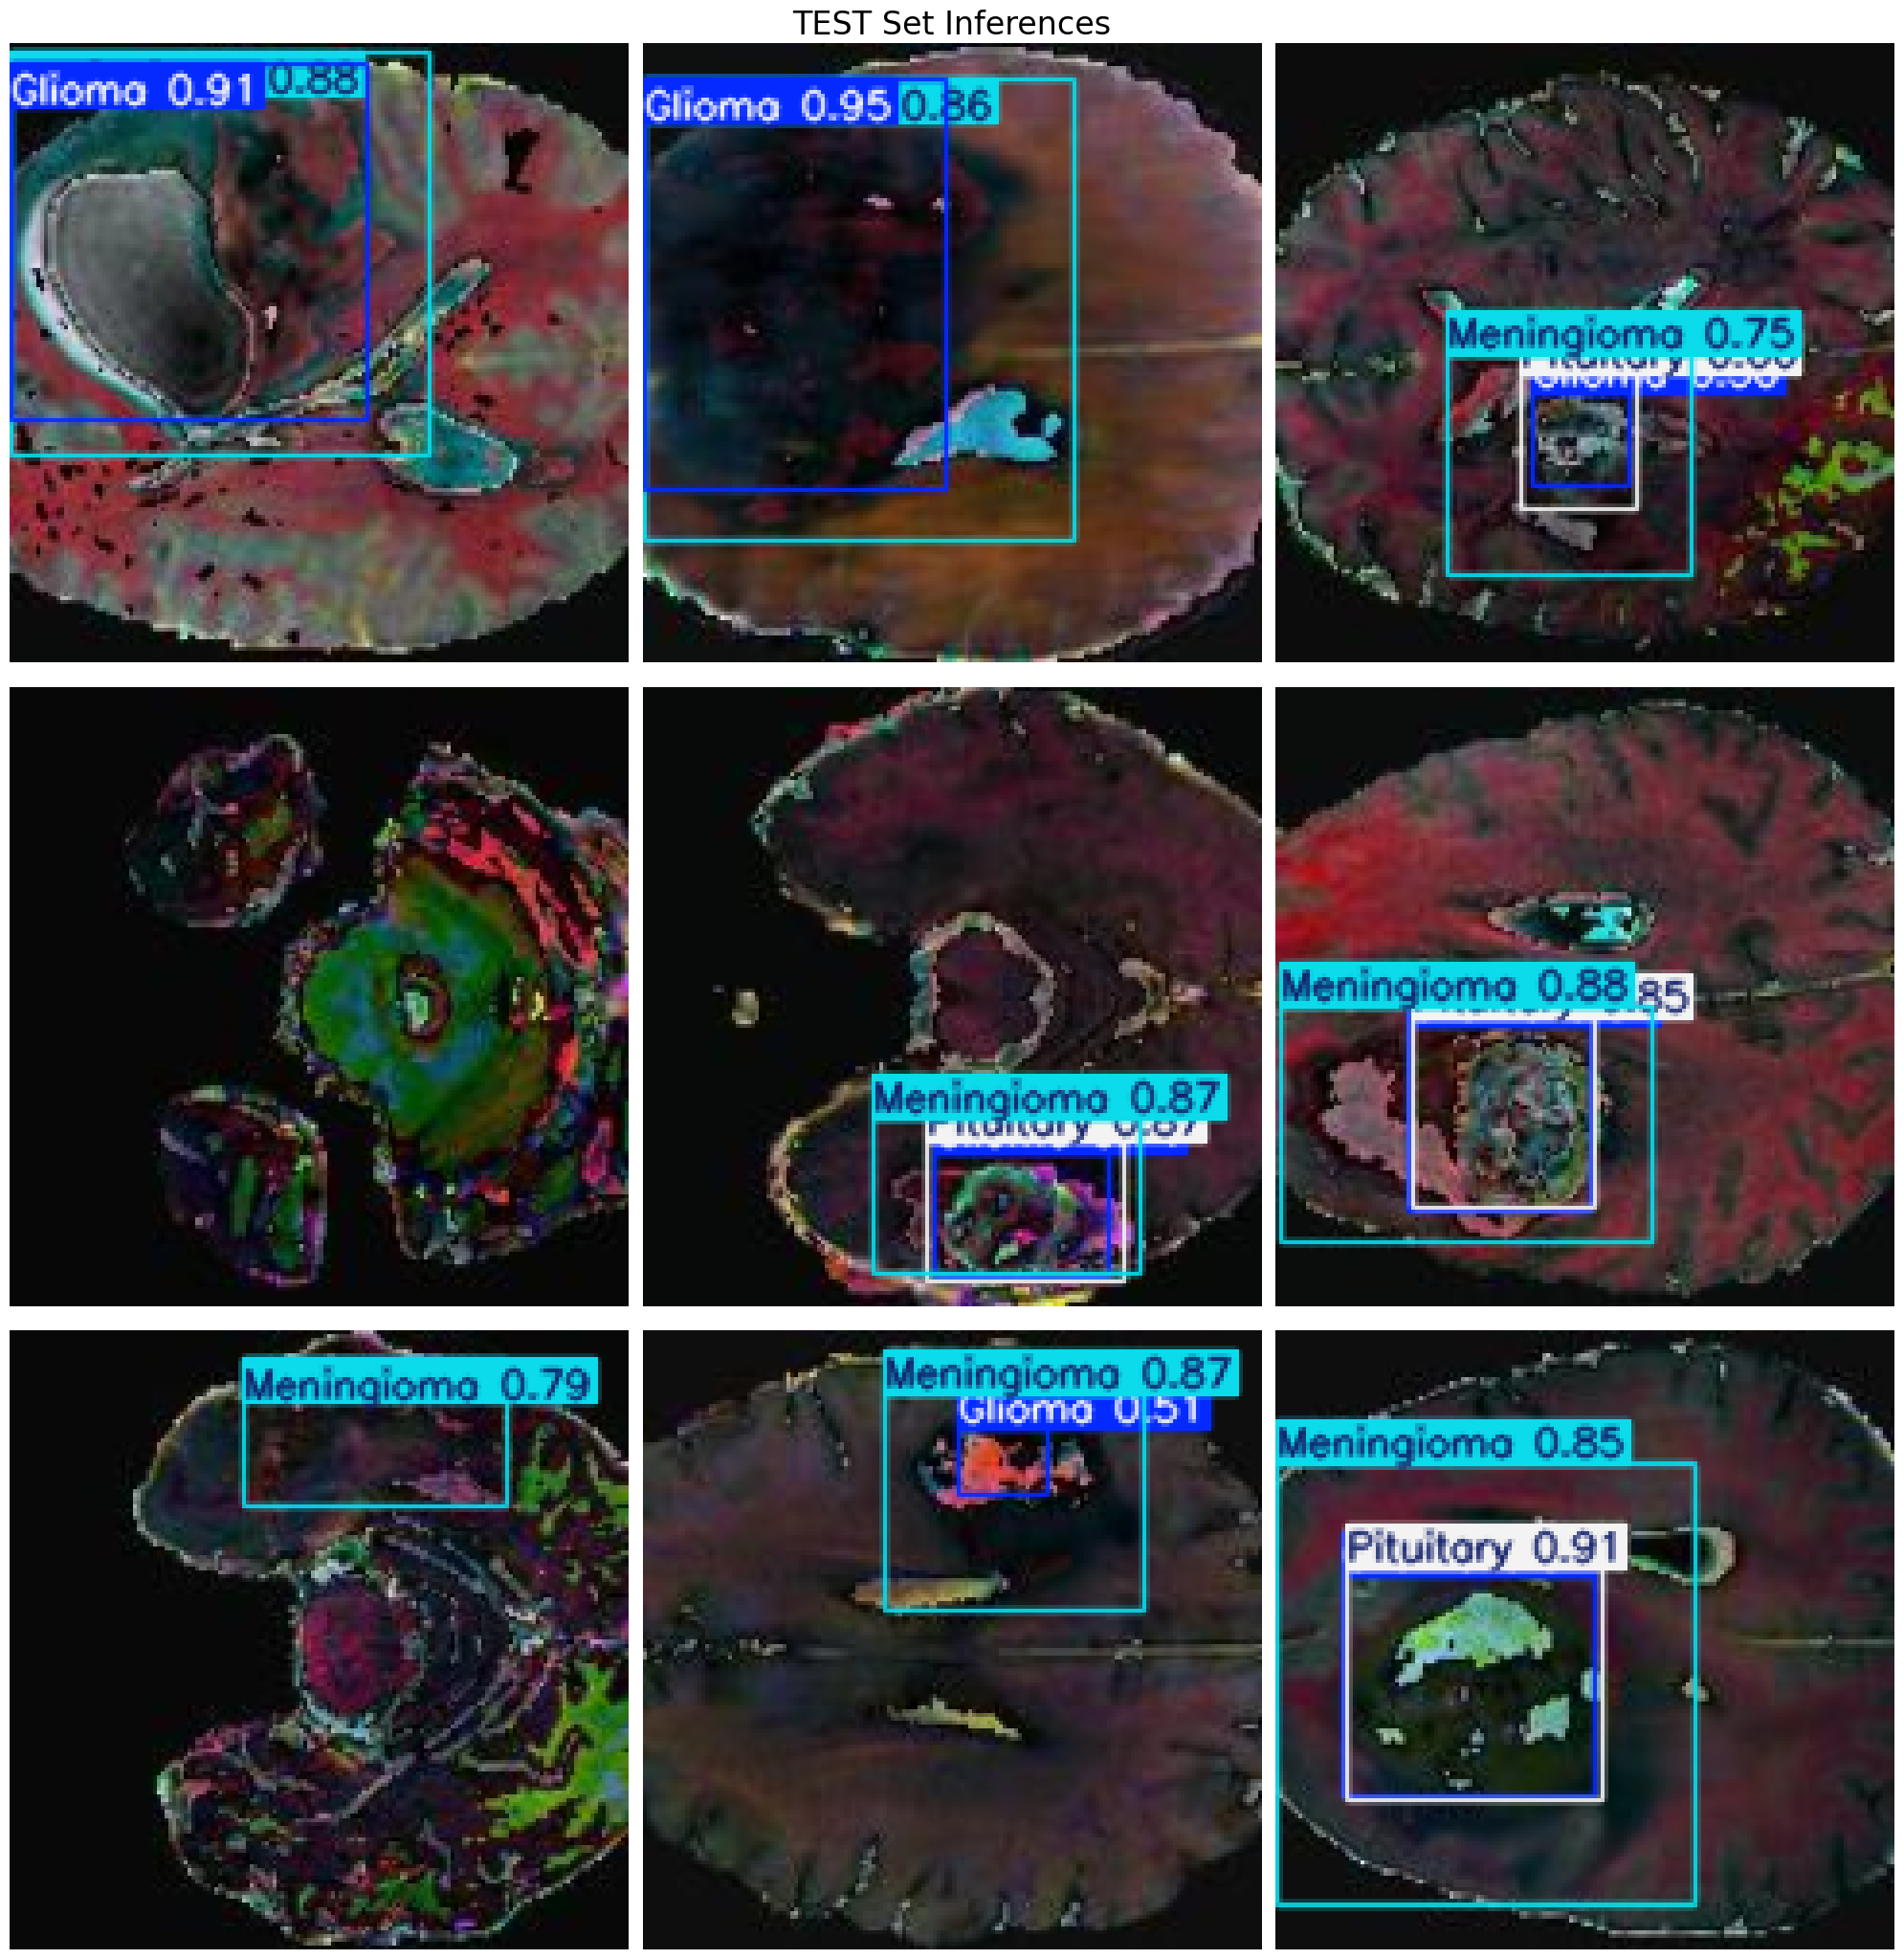

In [18]:
# Normalization function
def normalize_image(image):
    return image / 255.0

# Image resizing function
def resize_image(image, size=(160, 160)):
    return cv2.resize(image, size)

# Path to validation images
dataset_path = '/kaggle/input/dataset-brain-tumor/Brain_Tumor_Detection'  # Place your dataset path here
valid_images_path = os.path.join(dataset_path, 'test', 'images')

# List of all jpg images in the directory
image_files = [file for file in os.listdir(valid_images_path) if file.endswith('.jpg')]

# Check if there are images in the directory
if len(image_files) > 0:
    # Select 9 images at equal intervals
    num_images = len(image_files)
    step_size = max(1, num_images // 9)  # Ensure the interval is at least 1
    selected_images = [image_files[i] for i in range(0, num_images, step_size)]

    # Prepare subplots
    fig, axes = plt.subplots(3, 3, figsize=(20, 21))
    fig.suptitle('TEST Set Inferences', fontsize=24)

    for i, ax in enumerate(axes.flatten()):
        if i < len(selected_images):
            image_path = os.path.join(valid_images_path, selected_images[i])
            
            # Load image
            image = cv2.imread(image_path)
            
            # Check if the image is loaded correctly
            if image is not None:
                # Resize image
                resized_image = resize_image(image, size=(160, 160))
                # Normalize image
                normalized_image = normalize_image(resized_image)
                
                # Convert the normalized image to uint8 data type
                normalized_image_uint8 = (normalized_image * 255).astype(np.uint8)
                
                # Predict with the model
                results = best_model.predict(source=normalized_image_uint8, imgsz=160, conf=0.5)
                
                # Plot image with labels
                annotated_image = results[0].plot(line_width=1)
                annotated_image_rgb = cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB)
                ax.imshow(annotated_image_rgb)
            else:
                print(f"Failed to load image {image_path}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

In [9]:
from ultralytics import YOLO

# Load the fine-tuned model
model = YOLO("/kaggle/input/neuroscan_model_v1/pytorch/default/1/best.pt")

# Path to the test data
test_data_path = "/kaggle/input/dataset-brain-tumor/Brain_Tumor_Detection/data.yaml"

# Run validation on the test data
results = model.val(
    data=test_data_path,  # Path to the test dataset YAML or folder with test images
    imgsz=160,            # Image size (same as used in training)
    batch=32,             # Batch size
    device=0              # Device to run evaluation on
)

# Print the main metrics
print("Test Results:")
print(f"mAP@0.5: {results.box.map50 * 100:.2f}%")       # mAP at IoU=0.5
print(f"mAP@0.5:0.95: {results.box.map * 100:.2f}%")    # mAP across IoU=0.5:0.95
print(f"Precision: {results.box.mp * 100:.2f}%")
print(f"Recall: {results.box.mr * 100:.2f}%")

# Calculate estimated accuracy based on precision and recall
precision = results.box.mp
recall = results.box.mr
# F1 Score for a rough estimate of accuracy
accuracy = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0  
print(f"Estimated Detection Accuracy: {accuracy * 100:.2f}%")

# Optional: Additional metrics can be printed if necessary
print("Class-wise Results:")
for i, name in enumerate(results.names):
    ap50 = results.box.ap50[i] if i < len(results.box.ap50) else 0
    ap = results.box.ap[i] if i < len(results.box.ap) else 0
    print(f"{name}: AP@0.5: {ap50 * 100:.2f}%, AP@0.5:0.95: {ap * 100:.2f}%")


Ultralytics 8.3.24 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 168 layers, 11,126,745 parameters, 0 gradients, 28.4 GFLOPs


val: Scanning /kaggle/input/dataset-brain-tumor/Brain_Tumor_Detection/valid/labels... 1980 images, 17 backgrounds, 0 corrupt: 100%|██████████| 1980/1980 [00:02<00:00, 836.67it/s]

val: WARNING ⚠️ Cache directory /kaggle/input/dataset-brain-tumor/Brain_Tumor_Detection/valid is not writeable, cache not saved.



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [00:09<00:00,  6.28it/s]


                   all       1980       4380      0.901      0.729      0.795       0.55
                Glioma       1246       1246       0.88      0.647       0.73      0.469
            Meningioma       1944       1944      0.924      0.835      0.882      0.666
             Pituitary       1190       1190      0.898      0.704      0.771      0.516
Speed: 0.0ms preprocess, 1.1ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to runs/detect/val4
Test Results:
mAP@0.5: 79.46%
mAP@0.5:0.95: 55.01%
Precision: 90.07%
Recall: 72.88%
Estimated Detection Accuracy: 80.57%
Class-wise Results:
0: AP@0.5: 73.03%, AP@0.5:0.95: 46.86%
1: AP@0.5: 88.23%, AP@0.5:0.95: 66.62%
2: AP@0.5: 77.13%, AP@0.5:0.95: 51.55%


In [ ]:
import shutil
# Create a zip file of the specific folder 'Brain-Tumor-Detection'
shutil.make_archive('/kaggle/working/run, 'zip', '/kaggle/working')


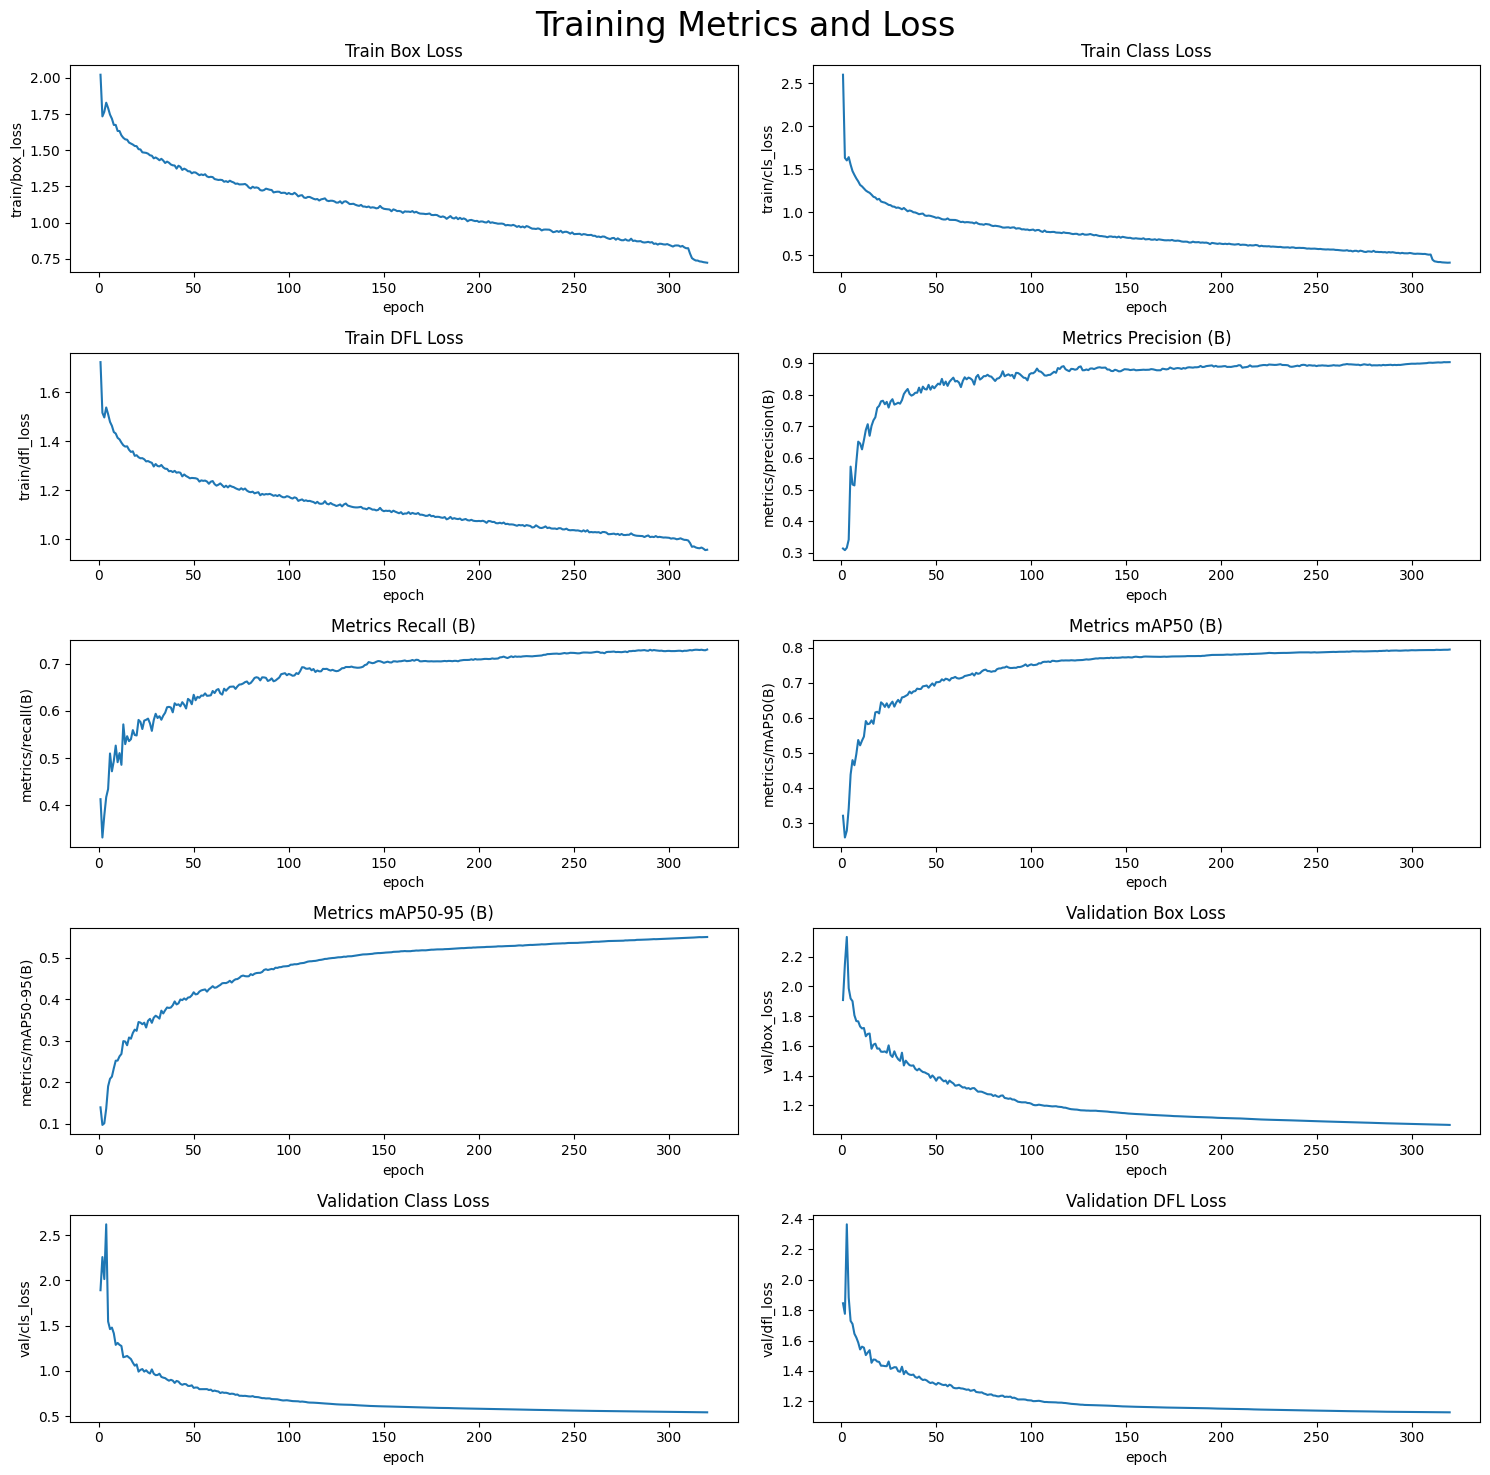

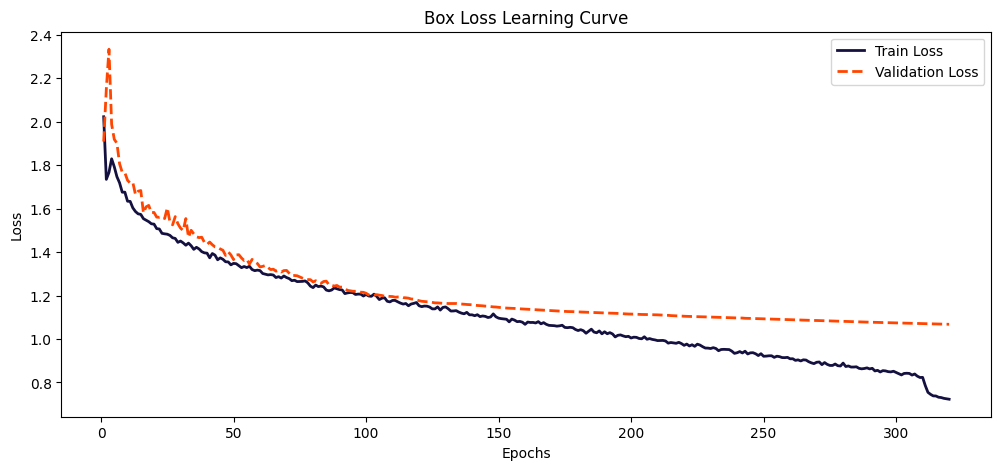

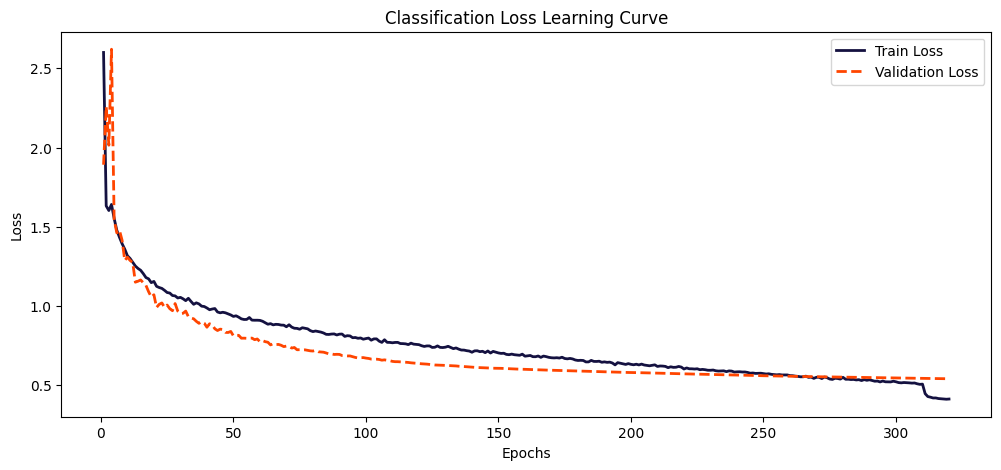

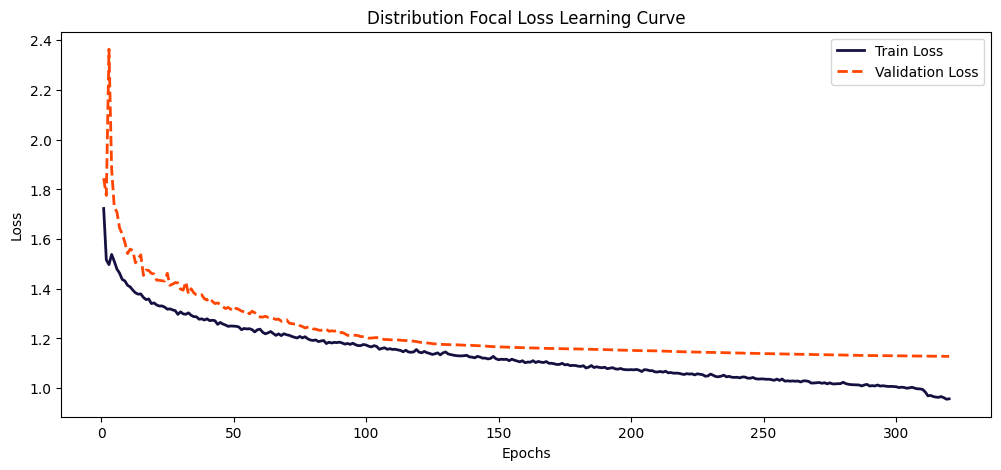

In [31]:
%matplotlib inline
# read in the results.csv file as a pandas dataframe
df = pd.read_csv('/kaggle/working/Brain-Tumor-Detection/yolov8_brain_tumor_detection/results.csv')

df.columns = df.columns.str.strip()

# create subplots using seaborn
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(15, 15))

# plot the columns using seaborn
sns.lineplot(x='epoch', y='train/box_loss', data=df, ax=axs[0,0])
sns.lineplot(x='epoch', y='train/cls_loss', data=df, ax=axs[0,1])
sns.lineplot(x='epoch', y='train/dfl_loss', data=df, ax=axs[1,0])
sns.lineplot(x='epoch', y='metrics/precision(B)', data=df, ax=axs[1,1])
sns.lineplot(x='epoch', y='metrics/recall(B)', data=df, ax=axs[2,0])
sns.lineplot(x='epoch', y='metrics/mAP50(B)', data=df, ax=axs[2,1])
sns.lineplot(x='epoch', y='metrics/mAP50-95(B)', data=df, ax=axs[3,0])
sns.lineplot(x='epoch', y='val/box_loss', data=df, ax=axs[3,1])
sns.lineplot(x='epoch', y='val/cls_loss', data=df, ax=axs[4,0])
sns.lineplot(x='epoch', y='val/dfl_loss', data=df, ax=axs[4,1])

# set titles and axis labels for each subplot
axs[0,0].set(title='Train Box Loss')
axs[0,1].set(title='Train Class Loss')
axs[1,0].set(title='Train DFL Loss')
axs[1,1].set(title='Metrics Precision (B)')
axs[2,0].set(title='Metrics Recall (B)')
axs[2,1].set(title='Metrics mAP50 (B)')
axs[3,0].set(title='Metrics mAP50-95 (B)')
axs[3,1].set(title='Validation Box Loss')
axs[4,0].set(title='Validation Class Loss')
axs[4,1].set(title='Validation DFL Loss')

# add suptitle and subheader
plt.suptitle('Training Metrics and Loss', fontsize=24)

# adjust top margin to make space for suptitle
plt.subplots_adjust(top=0.8)

# adjust spacing between subplots
plt.tight_layout()

plt.show()

# Remove any leading whitespace from the column names
df.columns = df.columns.str.strip()

# Plot the learning curves for each loss
plot_learning_curve(df, 'train/box_loss', 'val/box_loss', 'Box Loss Learning Curve')
plot_learning_curve(df, 'train/cls_loss', 'val/cls_loss', 'Classification Loss Learning Curve')
plot_learning_curve(df, 'train/dfl_loss', 'val/dfl_loss', 'Distribution Focal Loss Learning Curve')

In [32]:

# Define a function to plot learning curves for loss values
def plot_learning_curve(df, train_loss_col, val_loss_col, title):
    plt.figure(figsize=(12, 5))
    sns.lineplot(data=df, x='epoch', y=train_loss_col, label='Train Loss', color='#141140', linestyle='-', linewidth=2)
    sns.lineplot(data=df, x='epoch', y=val_loss_col, label='Validation Loss', color='orangered', linestyle='--', linewidth=2)
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

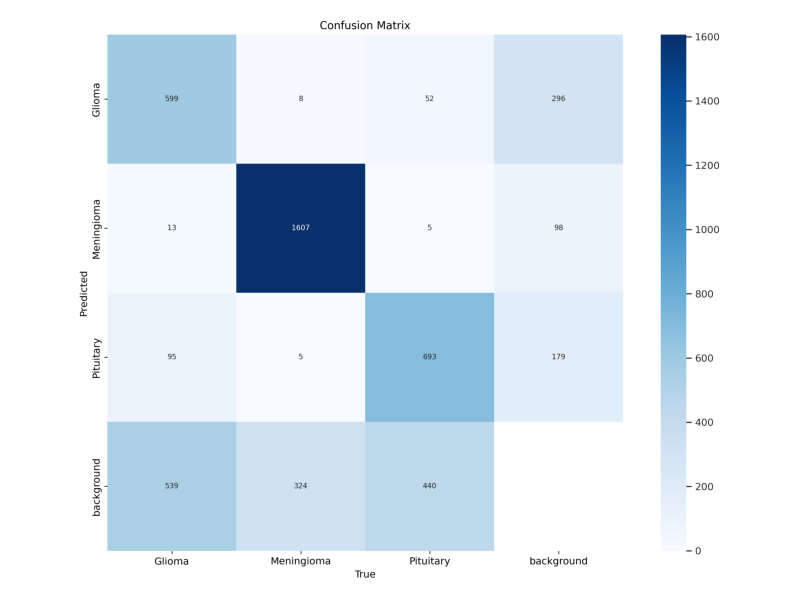

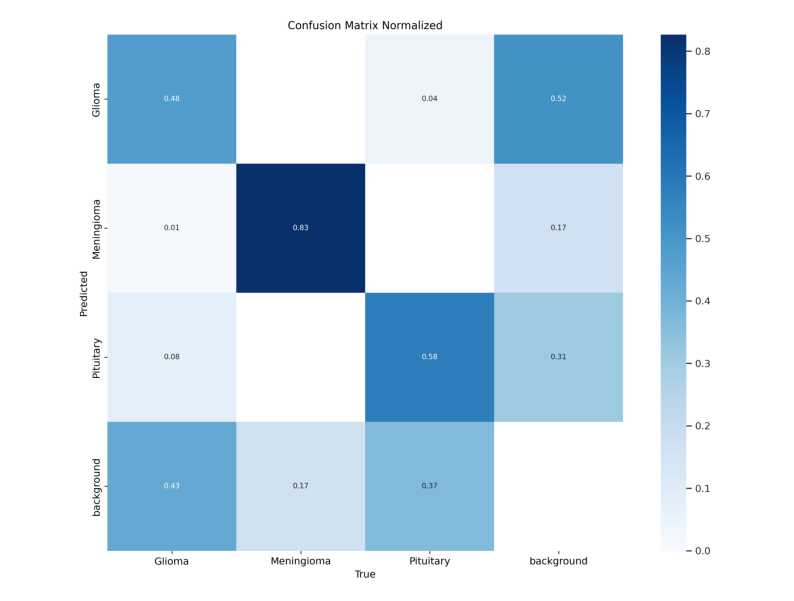

In [33]:
%matplotlib inline
# Reading the confusion matrix image file
img = mpimg.imread('//kaggle/working/Brain-Tumor-Detection/yolov8_brain_tumor_detection/confusion_matrix.png')

# Plotting the confusion matrix image
fig, ax = plt.subplots(figsize = (10, 10))

ax.imshow(img)
ax.axis('off');

# Reading the confusion matrix image file
img = mpimg.imread('/kaggle/working/Brain-Tumor-Detection/yolov8_brain_tumor_detection/confusion_matrix_normalized.png')

# Plotting the confusion matrix image
fig, ax = plt.subplots(figsize = (10, 10))

ax.imshow(img)
ax.axis('off');

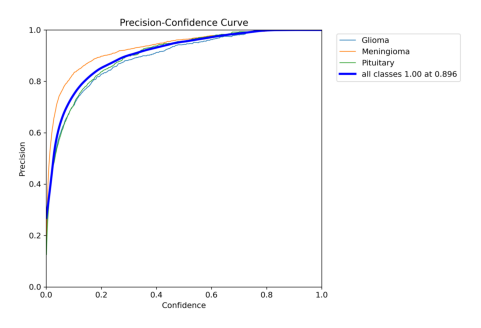

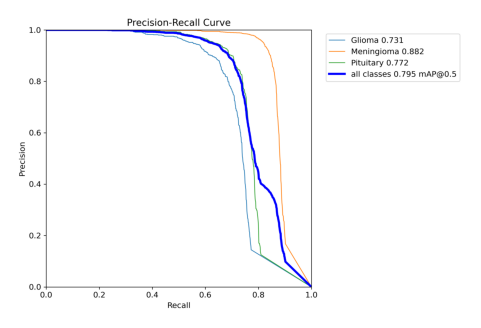

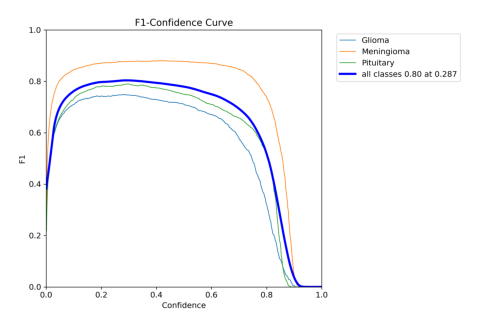

In [34]:
%matplotlib inline


# Reading the confusion matrix image file
img = mpimg.imread('/kaggle/working/Brain-Tumor-Detection/yolov8_brain_tumor_detection/P_curve.png')
# Plotting the confusion matrix image
fig, ax = plt.subplots(figsize = (18, 4))
ax.imshow(img)
ax.axis('off');


# Reading the confusion matrix image file
img = mpimg.imread('/kaggle/working/Brain-Tumor-Detection/yolov8_brain_tumor_detection/PR_curve.png')
# Plotting the confusion matrix image
fig, ax = plt.subplots(figsize = (18, 4))
ax.imshow(img)
ax.axis('off');

# Reading the confusion matrix image file
img = mpimg.imread('/kaggle/working/Brain-Tumor-Detection/yolov8_brain_tumor_detection/F1_curve.png')
# Plotting the confusion matrix image
fig, ax = plt.subplots(figsize = (18,4))
ax.imshow(img)
ax.axis('off');


image 1/1 /kaggle/input/dataset-brain-tumor/Brain_Tumor_Detection/test/images/volume_199_slice_80_jpg.rf.dc213397ee057866cee15f755ff5adba.jpg: 160x160 1 Meningioma, 1 Pituitary, 13.8ms
Speed: 1.0ms preprocess, 13.8ms inference, 1.9ms postprocess per image at shape (1, 3, 160, 160)

image 1/1 /kaggle/input/dataset-brain-tumor/Brain_Tumor_Detection/test/images/volume_260_slice_51_jpg.rf.474660801a03e03fa7d4b0b5227752f1.jpg: 160x160 1 Glioma, 1 Meningioma, 1 Pituitary, 6.7ms
Speed: 0.5ms preprocess, 6.7ms inference, 1.2ms postprocess per image at shape (1, 3, 160, 160)

image 1/1 /kaggle/input/dataset-brain-tumor/Brain_Tumor_Detection/test/images/volume_313_slice_74_jpg.rf.5464558c0e5fd546ceee93ebde80bb8e.jpg: 160x160 1 Meningioma, 6.5ms
Speed: 0.4ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 160, 160)

image 1/1 /kaggle/input/dataset-brain-tumor/Brain_Tumor_Detection/test/images/volume_208_slice_94_jpg.rf.1eb943d9bc34714ebf8263334450987a.jpg: 160x160 1 Glio

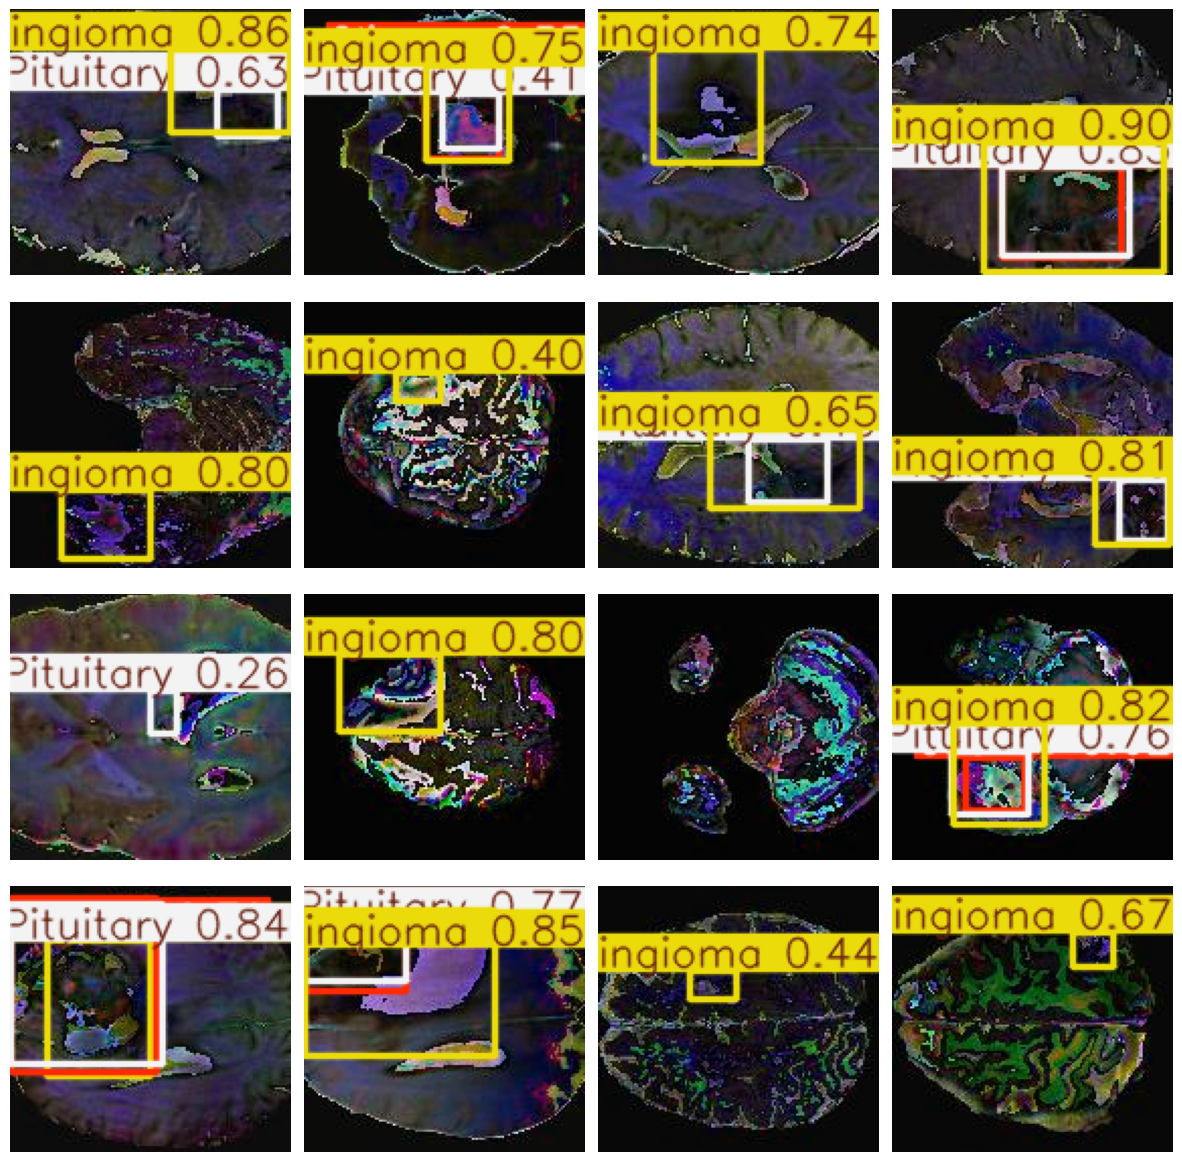

In [38]:
import os
import random
import matplotlib.pyplot as plt
from ultralytics import YOLO

# Load your trained YOLO model
model = YOLO('/kaggle/working/Brain-Tumor-Detection/yolov8_brain_tumor_detection/weights/best.pt')  # Make sure this path points to your model

# Define the directory where the custom images are stored
custom_image_dir = '/kaggle/input/dataset-brain-tumor/Brain_Tumor_Detection/test/images'

# Get the list of image files in the directory
image_files = os.listdir(custom_image_dir)

# Select 16 random images from the list
selected_images = random.sample(image_files, 16)

# Create a figure with subplots for each image
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(15, 15))

# Iterate over the selected images and plot each one
for i, img_file in enumerate(selected_images):
    
    # Compute the row and column index of the current subplot
    row_idx = i // 4
    col_idx = i % 4
    
    # Load the current image and run object detection
    img_path = os.path.join(custom_image_dir, img_file)
    
    # Run detection on the image using your YOLO model
    results = model(img_path)
    
    # Get the detected image with bounding boxes
    detect_img = results[0].plot()  # Or use 'results.show()' if you want to display directly
    
    # Plot the current image on the appropriate subplot
    axes[row_idx, col_idx].imshow(detect_img)
    axes[row_idx, col_idx].axis('off')

# Adjust the spacing between the subplots
plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.show()


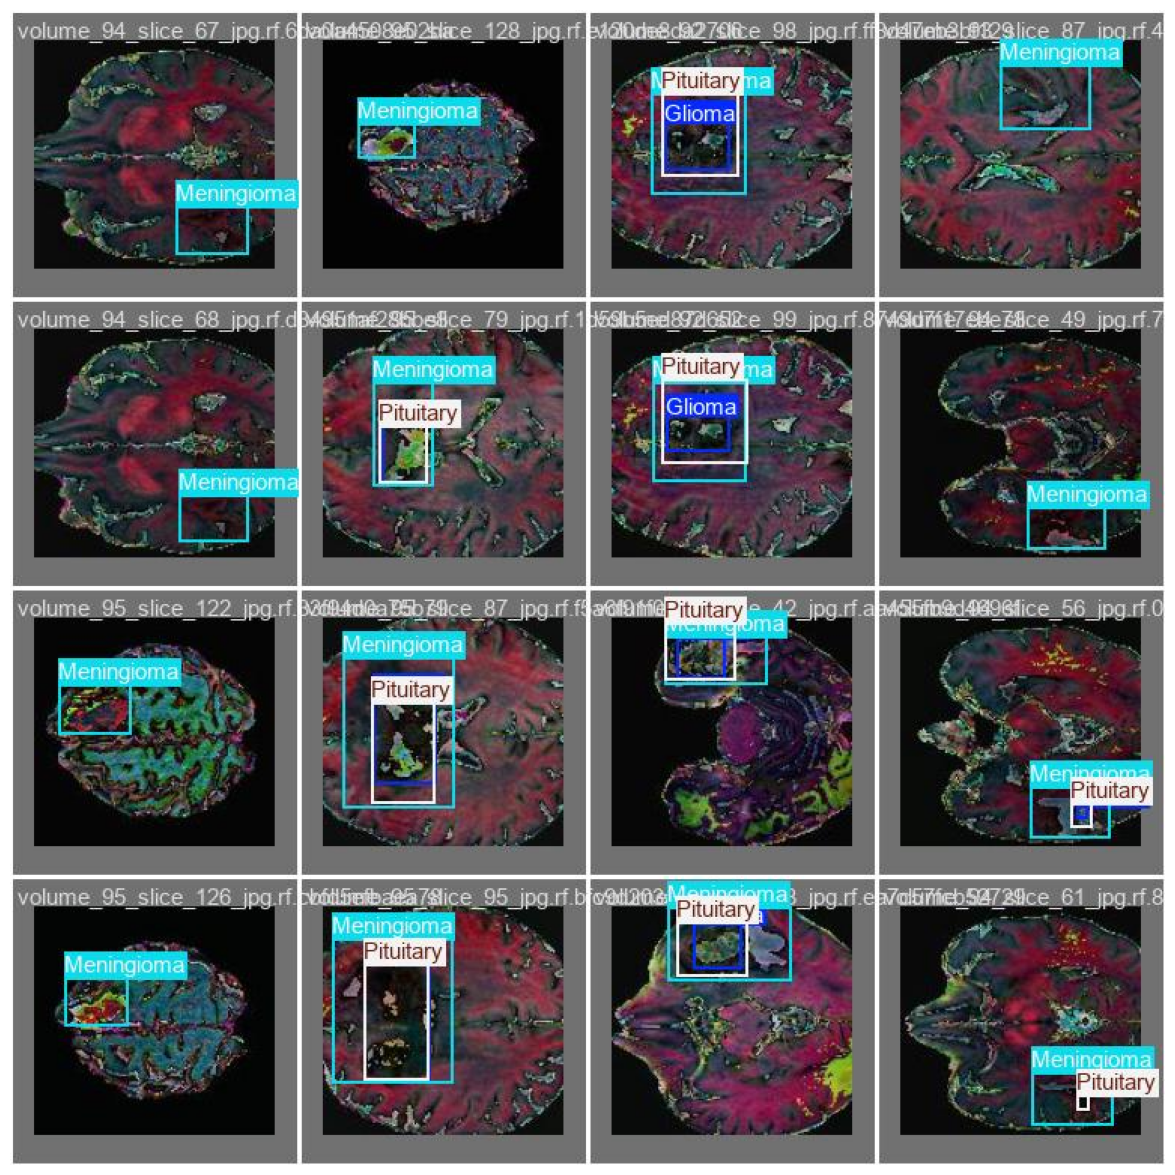

In [39]:
# Reading the confusion matrix image file
img = mpimg.imread('/kaggle/working/Brain-Tumor-Detection/yolov8_brain_tumor_detection/val_batch0_labels.jpg')

# Plotting the confusion matrix image
fig, ax = plt.subplots(figsize = (15, 15))

ax.imshow(img)
ax.axis('off');

In [40]:
model = YOLO('/kaggle/working/Brain-Tumor-Detection/yolov8_brain_tumor_detection/weights/best.pt')  # load a custom model

# Predict with the model
results = model('/kaggle/input/dataset-brain-tumor/Brain_Tumor_Detection/test/images/volume_100_slice_47_jpg.rf.5a4036c4db721c7a2501e756d91915a6.jpg')  # pred


image 1/1 /kaggle/input/dataset-brain-tumor/Brain_Tumor_Detection/test/images/volume_100_slice_47_jpg.rf.5a4036c4db721c7a2501e756d91915a6.jpg: 160x160 1 Meningioma, 8.9ms
Speed: 0.5ms preprocess, 8.9ms inference, 1.3ms postprocess per image at shape (1, 3, 160, 160)


In [41]:
new_results=model.predict(source="/kaggle/input/dataset-brain-tumor/Brain_Tumor_Detection/test/images/volume_100_slice_47_jpg.rf.5a4036c4db721c7a2501e756d91915a6.jpg",
              save=True, conf=0.2,iou=0.5)

new_result = new_results[0]


image 1/1 /kaggle/input/dataset-brain-tumor/Brain_Tumor_Detection/test/images/volume_100_slice_47_jpg.rf.5a4036c4db721c7a2501e756d91915a6.jpg: 160x160 1 Meningioma, 7.8ms
Speed: 0.6ms preprocess, 7.8ms inference, 1.3ms postprocess per image at shape (1, 3, 160, 160)
Results saved to runs/detect/predict


In [42]:
# Load your model
model = YOLO('/kaggle/working/Brain-Tumor-Detection/yolov8_brain_tumor_detection/weights/best.pt')  # For example, 'yolov8n.pt'
# Run prediction
results = model('/kaggle/input/dataset-brain-tumor/Brain_Tumor_Detection/test/images/volume_100_slice_47_jpg.rf.5a4036c4db721c7a2501e756d91915a6.jpg')

# Now, iterate over detected objects
for det in results[0].boxes:
    # det is now a single detection with attributes you can directly access
    xmin, ymin, xmax, ymax = det.xyxy[0]  # Coordinates
    conf = det.conf  # Confidence
    cls = det.cls  # Class ID
    print(f"Box coordinates: {xmin}, {ymin}, {xmax}, {ymax}, Confidence: {conf}, Class ID: {cls}")


image 1/1 /kaggle/input/dataset-brain-tumor/Brain_Tumor_Detection/test/images/volume_100_slice_47_jpg.rf.5a4036c4db721c7a2501e756d91915a6.jpg: 160x160 1 Meningioma, 6.2ms
Speed: 0.4ms preprocess, 6.2ms inference, 1.2ms postprocess per image at shape (1, 3, 160, 160)
Box coordinates: 53.717262268066406, 13.416831970214844, 111.35729217529297, 37.795677185058594, Confidence: tensor([0.7820], device='cuda:0'), Class ID: tensor([1.], device='cuda:0')


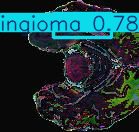

In [47]:
# Assuming `new_results` contains your detection results from a YOLO model
res_plotted = new_results[0].plot()  # Get the plotted result (image with detections)

# Convert the image from BGR (OpenCV format) to RGB (PIL format)
res_plotted = cv2.cvtColor(res_plotted, cv2.COLOR_BGR2RGB)

# Display the image using PIL's Image module
display(Image.fromarray(res_plotted))
